# Figures for Barnard 5 at large and small scale

In this notebook, we do the figures for all data, from large scale to small scale and the comparison between them.
These were in two separate notebooks, one for ALMA and another one for NOEMA, but it is more convenient to have all figures in one place.


In [1]:
import numpy as np
import os
from spectral_cube import SpectralCube
from B5setup import * # needs B5setup.py in the same folder
from scipy import stats
import velocity_tools.stream_lines as SL

# astropy
from astropy.modeling.models import Gaussian1D
import astropy.units as u
from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import SkyCoord, FK5
import aplpy
from regions import Regions

# matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.patches import Circle, Ellipse


%matplotlib inline

figdir = 'figures/'

## Useful functions

In [2]:
# definition of constants and fuctions

def degtohoursRA(deg):
    hours = deg / 360 * 24
    hh = np.trunc(hours).astype('int64')
    minutes = ((hours-hh) % 60) * 60
    mm = np.trunc(minutes).astype('int64')
    seconds = ((minutes-mm) % 60) * 60
    ss = np.round(seconds, 2)
    return '{0:02d}:{1:02d}:{2:0>5}'.format(hh, mm, ss)


def degtohoursDEC(deg):
    dd = np.trunc(deg).astype('int64')
    minutes = ((np.abs(deg)-np.abs(dd)) % 60) * 60
    mm = np.trunc(minutes).astype('int64')
    seconds = ((minutes-mm) % 60) * 60
    ss = np.round(seconds, 2)
    return '{0:02d}:{1:02d}:{2:0>5}'.format(dd, mm, ss)

def hourstodegRA(hours, minutes, seconds):
    deg = 15 * hours + 60 * minutes + 60 * seconds    
    return deg

def degtodegDEC(degrees, minutes, seconds):
    deg = degrees + 60 * minutes + 60 * seconds    
    return deg

def getPositionFromRegions(regionfile):
    regionload = Regions.read(regionfile)
    positions = [[regionload[i].center.ra.value, regionload[i].center.dec.value] for i in range(len(regionload))]
    regionlabels = [regionload[i].meta['label'] for i in range(len(regionload))]
    return positions, regionlabels

def get_spectra(cube, position, velstart, velend):
    '''
    Extracts the spectra (velocity, intensity) given a cube.
    
    Returns the spectra of the cube given, in the native units of the cube. 
    
    Args:
        cube (SpectralCube): datacube 
        position (NDarray): array size 2 containing ra and dec
        velstart (astropy.units): initial velocity of the spectra in u.km/u.s
        velend (astropy.units): final velocity of the spectra in u.km/u.s
    '''
    cubenew = cube.spectral_slab(velstart, velend)
    cubehead = cubenew.header
    bmaj = cubehead['bmaj'] * u.deg
    bmin = cubehead['bmin'] * u.deg
    beamarea = (1.133 * bmaj * bmin).to(u.arcsec**2)
    if 'restfreq' in cubehead._keyword_indices:
        restfreq = cubehead['restfreq'] * u.Hz
    else:
        restfreq = cubehead['restfrq'] * u.Hz
    cubewcs = WCS(cubehead)
    ra, dec = cubewcs.celestial.all_world2pix(position[0], position[1], 0)
#     rah = degtohoursRA(position[0])
#     dech = degtohoursDEC(position[1])
    velocities = cubenew.spectral_axis
    intensities = cubenew[:, int(dec), int(ra)]
    return velocities, intensities

def get_parameters_spectra(paramcube, position, header):
    '''
    This function returns all the contents in the cube along the spectra. 
    This means it returns errors as well if the paramscube includes them
    
    Args:
        paramcube (ndarray): cube with the parameters and errors for each parameter
        position (NDarray): array size 2 containing ra and dec in degrees
        header (SpectralCube.header): header to transform the wcs into pixel positions
    '''
    cubewcs = WCS(header)
    ra, dec = cubewcs.celestial.wcs_world2pix([position[0]], [position[1]], 0)
    ra = ra[0]
    dec = dec[0]
    params = paramcube[:, int(dec), int(ra)]
    return params

## NOEMA + 30m observations: HC$_3$N


### Filenames

In [127]:
# HC3N files
filedir = 'B5_NOEMA_30m/'
fitdir = filedir + 'gaussfit/'

# File in K and in km/s
imagefile = filedir + "B5-NOEMA+30m-H3CN-10-9_cut_K"
imagefile_87 = filedir + "B5-NOEMA+30m-H3CN-8-7_cut_K"
smallimagefile = filedir + "B5-NOEMA+30m-H3CN-10-9_cut_K_B5zoom"
x0, y0, x1, y1 = 83, 131, 133, 180
mom0file = imagefile + '_int_9.2_11.2.fits'
mom0file87 = imagefile_87 + '_int_9.2_11.2'

rmsKkmsHC3N = 0.15
rmsfile = fitdir +  'B5-NOEMA+30m-H3CN-10-9_cut_K_rms'
snrfile = fitdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_snr'
tpeakfile = fitdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_Tpeak'
maskfile = fitdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_mask'
initguessfile = fitdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_guesses.fits'
colorHC3N = '#984ea3'
positionfile = 'B5_NOEMA_30m/figures/B5_IRS1.reg'
positionfile_hook = 'B5_NOEMA_30m/figures/samples_South.reg'

fitfile =  fitdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_1G_fitparams_2.fits'
fitfilefiltered = fitdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_1G_fitparams_2_filtered.fits'
fitfilefiltered_vlsr = fitdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_1G_fitparams_filtered_Vlsr.fits'
fitfilefiltered_vlsr_conv = fitdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_1G_fitparams_filtered_Vlsr_conv_NH3.fits'

fitfile2 = fitdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_B5zoom_2G_fitparams2.fits'
fitfile2filtered = fitdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_B5zoom_2G_fitparams2_filtered.fits'

# line ratio map
ratiomapfile = filedir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_int_9.2_11.2_convolved_regrid_over_8_7.fits'
# column density map
Ntotmapfile = filedir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_int_9.2_11.2_Ntot.fits'

In [4]:
# VLA+GBT files from Pineda et al 2015
vlafolder = 'B5_previous_data/'
maskC1file = vlafolder + 'mask_C1.fits'
maskC2file = vlafolder + 'mask_C2.fits'
maskC3file = vlafolder + 'mask_C3.fits'
nh3mom0file = vlafolder + 'B5_VLA_GBT_model_11_mom0_reproject.fits'
nh3mom0levels = [0.1]
nh3velocityfile = vlafolder + 'B5_VLA_GBT_model_vc_QA_reprojectHC3N.fits' # check if using the original for the plot is better
# MASSES survey files from Stephens et al 2019
massesfolder = 'B5_previous_data/'
CO21fileblue = massesfolder + 'Per53.12CO21.robust1_blue.fits'
CO21filered = massesfolder + 'Per53.12CO21.robust1_red.fits'
bluecontlevels = [0.82+i*1.3 for i in range(4)]
redcontlevels = [1.2+i*2.1 for i in range(4)] # in Jy/beam km/s

### Moment 0 maps of HC$_3$N ($10-9$)

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cm.set_bad(color)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found w

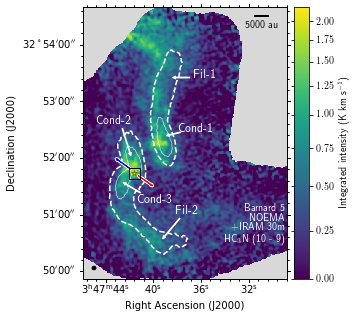

In [5]:
savefigure = False
fig = plt.figure(figsize=(5,5))
figname = figdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_mom0_9.2_11.2_woutflow.pdf'

gc = plot_aplpy_subfig(mom0file, fig, (1,1,1), 'arcsinh', 0, 2.2, 'viridis', vmid=0.8, showframeScalebar=False)
gc.show_contour(maskC1file, colors='w', linewidths=0.5)
gc.add_label(0.55, 0.55, 'Cond-1', relative=True, color='w', size=12)
gc.show_contour(maskC2file, colors='w', linewidths=0.5)
gc.add_label(0.15, 0.58, 'Cond-2', relative=True, color='w', size=12)
gc.show_contour(maskC3file, colors='w', linewidths=0.5)
gc.add_label(0.35, 0.29, 'Cond-3', relative=True, color='w', size=12)

gc.show_arrows([56.9071283, 56.9275561, 56.9212545, 56.9039327, 56.9074336], 
               [32.8742579, 32.8753517, 32.8564551, 32.8903704, 32.8489104], 
               [0.005, -0.003, 0.006, 0.006, 0.006], [-0.001, -0.008, 0.003, 0, -0.006], color='w', width=1, head_width=4, head_length=4)
# filament outline from NH3(1,1)
gc.show_contour(nh3mom0file, colors='w', linestyles='dashed', levels=nh3mom0levels, zorder=34)
gc.add_label(0.6, 0.75, 'Fil-1', relative=True, color='w', size=12)
gc.add_label(0.51, 0.25, 'Fil-2', relative=True, color='w', size=12)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.5, layer='lay_yso',  facecolor='None', edgecolor='k')
gc.recenter(56.9055921,32.8711272,width=0.06,height=0.08)
gc.add_label(0.99,0.20, 'Barnard 5\nNOEMA\n+IRAM 30m\nHC$_3$N (10 - 9)', relative=True, color='w', size=10, horizontalalignment='right')
gc.colorbar.set_axis_label_text(r'Integrated intensity (K km s$^{-1}$)')
gc.colorbar.set_pad(0.1)
gc.show_rectangles([ra_yso], [dec_yso], 0.0015*2, 0.0015*2, edgecolor='k', facecolor='none', zorder=1000)

# if you want to add the mask contour
# gc.show_contour(maskfile+'.fits', colors='white', linewidths=0.5, levels=[1])
# if you want to add arrows with the direction of the outflow
gc.show_arrows(56.9249180, 32.8636213, 0.005, 0.003, color='w', zorder=100, linewidth=3)
gc.show_arrows(56.9249180, 32.8636213, 0.005, 0.003, color='b', zorder=100)
gc.show_arrows(56.9220945, 32.8616098, -0.005, -0.003, color='w', linewidth=3)
gc.show_arrows(56.9220945, 32.8616098, -0.005, -0.003, color='r', zorder=100)

if savefigure:
    fig.savefig(figname, bbox_inches='tight', dpi=300)

### Moment 0 maps of HC$_3$N ($8-7$)

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cm.set_bad(color)


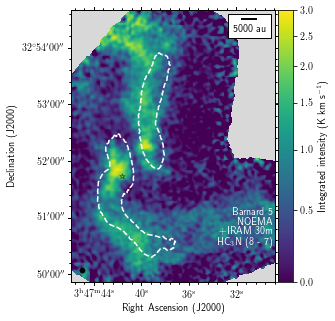

In [6]:
savefigure = True
fig = plt.figure(figsize=(5,5))
figname = figdir + 'B5-NOEMA+30m-H3CN-8-7_cut_K_mom0_9.2_11.2.pdf'

gc = plot_aplpy_subfig(mom0file87+'.fits', fig, (1,1,1), 'arcsinh', 0, 3, 'viridis', vmid=1, showframeScalebar=True)
# gc.show_contour(maskC1file, colors='w', linewidths=0.5)
# gc.add_label(0.55, 0.55, 'Cond-1', relative=True, color='w', size=12)
# gc.show_contour(maskC2file, colors='w', linewidths=0.5)
# gc.add_label(0.15, 0.58, 'Cond-2', relative=True, color='w', size=12)
# gc.show_contour(maskC3file, colors='w', linewidths=0.5)
# gc.add_label(0.35, 0.29, 'Cond-3', relative=True, color='w', size=12)

# filament outline from NH3(1,1)
gc.show_contour(nh3mom0file, colors='w', linestyles='dashed', levels=nh3mom0levels, zorder=34)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.5, layer='lay_yso',  facecolor='None', edgecolor='k')
gc.recenter(56.9055921,32.8711272,width=0.06,height=0.08)
gc.add_label(0.99,0.20, 'Barnard 5\nNOEMA\n+IRAM 30m\nHC$_3$N (8 - 7)', relative=True, color='w', size=10, horizontalalignment='right')
gc.colorbar.set_axis_label_text(r'Integrated intensity (K km s$^{-1}$)')

if savefigure:
    fig.savefig(figname, bbox_inches='tight', dpi=300)

### Channel maps of HC$_3$N ($10-9$)

In [7]:
cube_HC3N = SpectralCube.read(imagefile+'.fits').with_spectral_unit(u.km/u.s)
wcssky = WCS(cube_HC3N.header).celestial    
ra_yso_pix, dec_yso_pix = wcssky.wcs_world2pix(ra_yso, dec_yso, 0)
ra_yso_pix, dec_yso_pix = float(ra_yso_pix), float(dec_yso_pix)

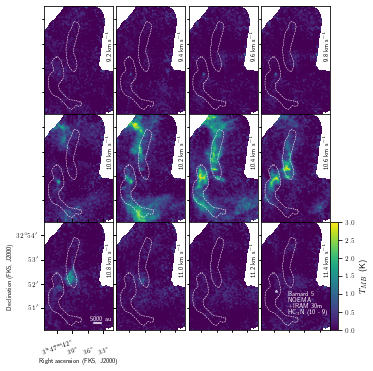

In [8]:
savefigure = True

velinit = 9.2 * u.km/u.s
deltav = 0.2 * u.km/u.s
figname = figdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_chanmap_{0}_{1}.pdf'.format(velinit.value,deltav.value)
nrows = 3
ncols = 4
vmax = 3
vmin = 0
xmin = 60
xmax = 280
ymin = 26
ymax = 370
velocity_array = cube_HC3N.spectral_axis.value
velocity_sample = np.arange(velinit.value, velinit.value+(nrows*ncols*deltav.value), deltav.value) 
bmaj, bmin = np.array([cube_HC3N.header['BMAJ'], cube_HC3N.header['BMIN']])/np.abs(cube_HC3N.header['CDELT2'])
bpa = cube_HC3N.header['BPA'] - 90
scalebarsize = 5000
scalebarpix = int((scalebarsize / dist_B5.value) / 3600 / cube_HC3N.header['CDELT2'])

contourdata = fits.getdata(nh3mom0file)

fig, axlist = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(6,6), subplot_kw={'projection': wcssky})
axlist = axlist.flatten()
for i, ax in enumerate(axlist):
    indexvel = np.argmin(np.abs(velocity_array-velocity_sample[i]))
    planevel = cube_HC3N.unmasked_data[indexvel, :, :]
    im = ax.imshow(planevel, vmin = vmin, vmax=vmax)
    ax.annotate(str(np.round(velocity_sample[i], 2))+r' km s$^{-1}$', (0.9, 0.5), xycoords='axes fraction', color='k', size=6, rotation=90)
    beam = Ellipse((32, 29), bmaj, bmin, angle=bpa, ec = 'w', fc='w')
    ax.add_patch(beam)
    # ax.scatter(ra_yso_pix, dec_yso_pix, marker='*', facecolor=None, edgecolor='w', s=8, linewidth=0.5)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.contour(contourdata, levels=nh3mom0levels, colors='w', linewidths=0.5, linestyles='dashed')
    if i == ncols*nrows-1:
        ax.scatter(ra_yso_pix, dec_yso_pix, marker='*', facecolor=None, edgecolor='w', s=8, linewidth=0.5) 
        ax.annotate('Barnard 5\nNOEMA\n+IRAM 30m\nHC$_3$N (10 - 9)', (0.4, 0.15), xycoords='axes fraction', color='w', size=6)
        
    if not i == ncols*nrows - ncols:
        ax.tick_params(axis='x', which='both', bottom=True, labelbottom=False, length=2)
        ax.tick_params(axis='y', which='both', left=True, labelleft=False, length=2)
    else:
        # ax.set_xlabel('Right ascension (FK5, J2000)')
        # ax.set_ylabel('Declination (FK5, J2000)')
        lon = ax.coords[0]
        lat = ax.coords[1]
        lon.set_axislabel('Right ascension (FK5, J2000)', size=6)
        lat.set_axislabel('Declination (FK5, J2000)', size=6)
        lat.set_ticklabel(size=6)
        lon.set_ticklabel(rotation=20,pad=15,ha='right', size=6)
        ax.plot([220, 220+scalebarpix], [50, 50], color='w', lw=1.5)
        ax.annotate(str(scalebarsize)+' au', (0.66, 0.09), xycoords='axes fraction', color='w', size=6)
        
fig.tight_layout(pad=0)
fig.subplots_adjust(left=0.2, right=0.98, bottom=0.15, top=0.9, hspace = 0, wspace=-0.4)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.25])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(label=r'$T_{MB}$ (K)', size=8)
cbar_ax.tick_params(labelsize=6)
# fig.subplots_adjust(hspace = 0, wspace=-0.5) 

if savefigure:
    fig.savefig(figname, dpi=300, bbox_inches='tight')
    

### Spectra of selected regions in HC$_3$N ($10-9$)

        Use another way of creating angles instead (e.g. a less ambiguous string like '-0h1m2.3s' instead. [astropy.coordinates.angles]
        Use another way of creating angles instead (e.g. a less ambiguous string like '-0d1m2.3s' instead. [astropy.coordinates.angles]


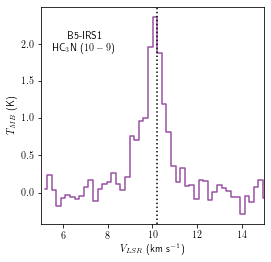

In [51]:
savefigure = True
positions, labels = getPositionFromRegions(positionfile)
position = positions[0]
velinit = 5 * u.km/u.s
velend = 15 * u.km/u.s
label = r'B5-IRS1 \\ HC$_3$N ($10-9$)'
figname = figdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_spectrum_B5IRS1.pdf'

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$V_{LSR}$ (km s$^{-1}$)')
ax.set_ylabel(r'$T_{MB}$ (K)')
spectrum = get_spectra(cube_HC3N, position, velinit, velend)
ax.plot(spectrum[0], spectrum[1], drawstyle='steps-mid', color=colorHC3N, label=r'HC$_3$N (10-9)')
ax.text(0.05, 0.85, label, horizontalalignment='left', transform=ax.transAxes, color='k', size=10)
ax.set_xlim([velinit.value, velend.value])
ax.axvline(10.21, color='k', linestyle='dotted', label=r'$V_{LSR}$ IRS1 (NH$_3$)')
# ax.legend(fontsize=8)

if savefigure:
    fig.savefig(figname, bbox_inches='tight', dpi=300)

### Results of the 1 Gaussian fit to HC$_3$N ($10-9$)

#### Maps of all parameters

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cm.set_bad(color)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found w

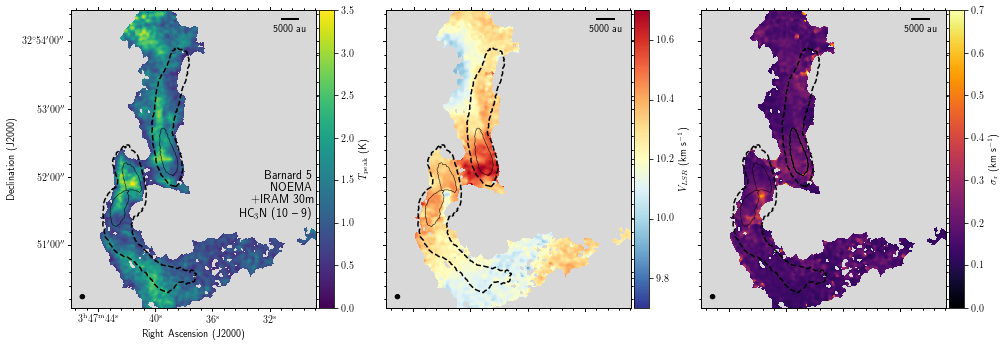

In [133]:
savefigure = True
fig = plt.figure(1, figsize=(16,8))
figname = figdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_1G_fitparams_filtered_results.pdf'

cube = fits.getdata(fitfilefiltered)
paramscube = np.array(cube[:3])
errcube = np.array(cube[3:])
headerplot = fits.getheader(tpeakfile + '.fits')
stretch = 'linear'
vmin = [0, 10.2-0.5, 0]
vmax = [np.round(np.nanmax(paramscube[0]), 1), 10.2+0.5, np.round(np.nanmax(paramscube[2]), 1)]
cmap = ['viridis', 'RdYlBu_r', 'inferno']
quantities = [r'$T_{\mathrm{peak}}$ (K)', r'$V_{LSR}$ (km s$^{-1}$)', r'$\sigma_{\mathrm{r}}$ (km s$^{-1}$)']

for i in range(len(paramscube)):
    ax0 = plot_aplpy_subfig(fits.PrimaryHDU(paramscube[i], headerplot), fig, (1,3,i+1), stretch, \
                            vmin[i], vmax[i], cmap[i])
    ax0.colorbar.set_axis_label_text(quantities[i])
    ax0.recenter(56.9055921,32.8711272,width=0.06,height=0.073)
    if i:
        ax0.tick_labels.hide()
        ax0.axis_labels.hide()
    else:
        ax0.add_label(0.99,0.38, 
                     'Barnard 5\nNOEMA\n+IRAM 30m\nHC$_3$N (10 -- 9)', 
                     relative=True, color='k', size=12, horizontalalignment='right')
    
    ax0.show_contour(maskC1file, colors='k', linewidths=0.5)
    ax0.show_contour(maskC2file, colors='k', linewidths=0.5)
    ax0.show_contour(maskC3file, colors='k', linewidths=0.5)
    # filament outline from NH3(1,1)g
    ax0.show_contour(nh3mom0file, colors='k', linestyles='dashed', levels=nh3mom0levels, zorder=34)
        
if savefigure:
    fig.savefig(figname, bbox_inches='tight', dpi=300)

#### Velocity maps

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  cm.set_bad(color)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  cm.set_bad(color)


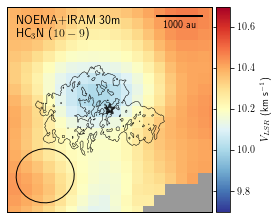

In [12]:
# velocity only with zoom into protostar
savefigure = True
figname = figdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_1G_fitparams_filtered_vlsr_ALMAcontour.pdf'

fig = plt.figure(1, figsize=(4,4))
velmin = 10.2-0.5
velmax = 10.2+0.5


filenamecontour = 'B5_IRS1_ALMA/gaussfit_H2CO/analysis_central_chans_masked/B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_1G_fitparams_total_aicres.fits'
filenameheader = 'B5_IRS1_ALMA/gaussfit_H2CO/analysis_central_chans_masked/B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_total_ncomponents.fits'
tpeak_h2coalma = fits.getdata(filenamecontour)[0]
tpeakheader = fits.getheader(filenameheader)
tpeak = np.where(~np.isnan(tpeak_h2coalma), 1,0)

ax = plot_aplpy_subfig(fitfilefiltered_vlsr, 
                       fig, (1,1,1), 'linear', velmin, 
                       velmax, 'RdYlBu_r', barsize=1000)

ax.tick_labels.set_xformat('hh:mm:ss.s')
ax.tick_labels.set_yformat('dd:mm:ss.s')
ax.ticks.hide()
ax.tick_labels.hide()
ax.axis_labels.hide()
ax.recenter(ra_yso, dec_yso, 0.002)
ax.beam.set_facecolor('None')
ax.show_contour(fits.PrimaryHDU(tpeak, tpeakheader), colors='k', levels=[0.5], linewidths=0.5)
ax.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k', s=100,linewidth=2)
ax.set_nan_color('0.6')
ax.add_label(0.05,0.9, 'NOEMA+IRAM 30m\nHC$_3$N ($10-9$)', 
                     relative=True, color='k', size=12, horizontalalignment='left')
ax.colorbar.set_axis_label_text(r'$V_{LSR}$ (km s$^{-1}$)')

if savefigure:
    fig.savefig(figname, bbox_inches='tight', dpi=300)

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  cm.set_bad(color)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  cm.set_bad(color)


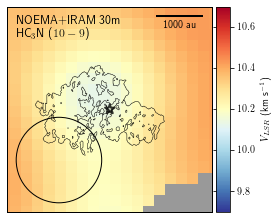

In [14]:
# velocity after convolution to NH3 beam, with zoom into protostar
savefigure = True
figname = figdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_1G_fitparams_filtered_vlsr_convNH3_ALMAcontour.pdf'

fig = plt.figure(1, figsize=(4,4))
velmin = 10.2-0.5
velmax = 10.2+0.5


filenamecontour = 'B5_IRS1_ALMA/gaussfit_H2CO/analysis_central_chans_masked/B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_1G_fitparams_total_aicres.fits'
filenameheader = 'B5_IRS1_ALMA/gaussfit_H2CO/analysis_central_chans_masked/B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_total_ncomponents.fits'
tpeak_h2coalma = fits.getdata(filenamecontour)[0]
tpeakheader = fits.getheader(filenameheader)
tpeak = np.where(~np.isnan(tpeak_h2coalma), 1,0)

ax = plot_aplpy_subfig(fitfilefiltered_vlsr_conv, 
                       fig, (1,1,1), 'linear', velmin, 
                       velmax, 'RdYlBu_r', barsize=1000)

ax.tick_labels.set_xformat('hh:mm:ss.s')
ax.tick_labels.set_yformat('dd:mm:ss.s')
ax.ticks.hide()
ax.tick_labels.hide()
ax.axis_labels.hide()
ax.recenter(ra_yso, dec_yso, 0.002)
ax.beam.set_facecolor('None')
ax.show_contour(fits.PrimaryHDU(tpeak, tpeakheader), colors='k', levels=[0.5], linewidths=0.5)
ax.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k', s=100,linewidth=2)
ax.set_nan_color('0.6')
ax.add_label(0.05,0.9, 'NOEMA+IRAM 30m\nHC$_3$N ($10-9$)', 
                     relative=True, color='k', size=12, horizontalalignment='left')
ax.colorbar.set_axis_label_text(r'$V_{LSR}$ (km s$^{-1}$)')

if savefigure:
    fig.savefig(figname, bbox_inches='tight', dpi=300)

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  cm.set_bad(color)


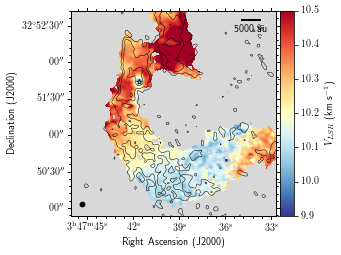

In [12]:
# velocity only with moment 0 contours, zoomed to to IRS1
savefigure = True
vlsrmap = paramscube[1]
headerplot = fits.getheader(fitfilefiltered_vlsr)
fig = plt.figure(1, figsize=(4,4))
velmin = 9.9
velmax = 10.5
figname = figdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_1G_fitparams_filtered_Vlsr_south.pdf'

ax = plot_aplpy_subfig(fits.PrimaryHDU(vlsrmap, headerplot), 
                       fig, (1,1,1), 'linear', velmin, 
                       velmax, 'RdYlBu_r')
# ax.add_label(0.6, 0.04, 
#              r'$V_{\mathrm{LSR}}$', 
#              relative=True, family='sans-serif', size=12)
ax.show_contour(mom0file, colors='k', levels=rmsKkmsHC3N*np.array([3,5,10]), linewidths=0.5)
ax.recenter(56.9139998, 32.8550135, 0.0234465)
ax.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k')
ax.colorbar.set_axis_label_text(r'$V_{LSR}$ (km s$^{-1}$)')

if savefigure:
    fig.savefig(figname, bbox_inches='tight')

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  cm.set_bad(color)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found 

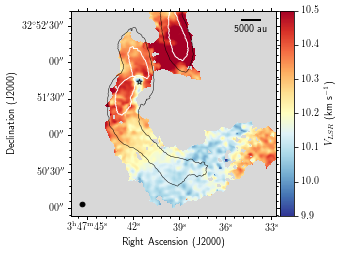

In [13]:
# velocity only with moment 0 and condensations in NH3
savefigure = True
vlsrmap = paramscube[1]
headerplot = fits.getheader(fitfilefiltered_vlsr)
fig = plt.figure(1, figsize=(4,4))
velmin = 9.9
velmax = 10.5
figname = figdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_1G_fitparams_filtered_Vlsr_south_condensations.pdf'

ax = plot_aplpy_subfig(fits.PrimaryHDU(vlsrmap, headerplot), 
                       fig, (1,1,1), 'linear', velmin, 
                       velmax, 'RdYlBu_r')
ax.show_contour(maskC1file, colors='w', linewidths=1)
ax.show_contour(maskC2file, colors='w', linewidths=1)
ax.show_contour(maskC3file, colors='w', linewidths=1)
ax.show_contour(nh3mom0file, colors='black', linewidths=0.5, levels=nh3mom0levels, zorder=34)
ax.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k')
ax.colorbar.set_axis_label_text(r'$V_{LSR}$ (km s$^{-1}$)')
ax.recenter(56.9139998, 32.8550135, 0.0234465)

if savefigure:
    fig.savefig(figname, bbox_inches='tight')

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  cm.set_bad(color)


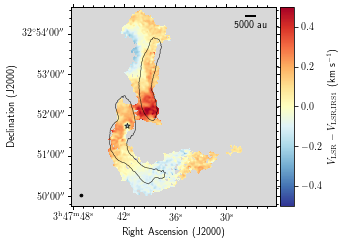

In [14]:
# Velocity with respect to the protostellar velocity (from Pineda et al 2015)
savefigure = True
vlsr_irs1 = 10.2 #km/s
diffvlsr = paramscube[1] - vlsr_irs1
diffmin = -0.5
diffmax = 0.5
headerplot = fits.getheader(fitfilefiltered_vlsr)
fig = plt.figure(1, figsize=(4,4))
figname = figdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_1G_fitparams_filtered_Vlsr_minus_irs1.pdf'

ax = plot_aplpy_subfig(fits.PrimaryHDU(diffvlsr, headerplot), 
                       fig, (1,1,1), 'linear', diffmin, 
                       diffmax, 'RdYlBu_r')

ax.show_contour(nh3mom0file, colors='black', linewidths=0.5, levels=nh3mom0levels, zorder=34)
ax.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k')
ax.colorbar.set_axis_label_text(r'$V_{\mathrm{LSR}} - V_{\mathrm{LSR}, \mathrm{IRS1}}$ (km s$^{-1}$)')
if savefigure:
    fig.savefig(figname, bbox_inches='tight')

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  cm.set_bad(color)


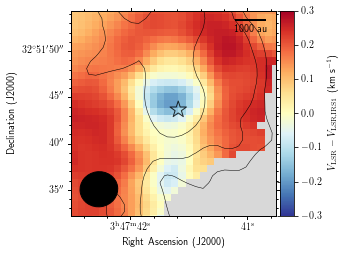

In [15]:
# zoomed near IRS1 with HC3N moment 0 contours where the 2G fit is made
savefigure = True

diffvlsr = paramscube[1] - vlsr_irs1
diffmin = -0.3
diffmax = 0.3
headerplot = fits.getheader(fitfilefiltered_vlsr)
fig = plt.figure(1, figsize=(4,4))
figname = figdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_1G_fitparams_filtered_Vlsr_minus_irs1_zoomB5_wcontmom0.pdf'

ax = plot_aplpy_subfig(fits.PrimaryHDU(diffvlsr, headerplot), 
                       fig, (1,1,1), 'linear', diffmin, 
                       diffmax, 'RdYlBu_r', barsize=1000)
ax.recenter(56.9234601, 32.8620242, 0.0030777)
ax.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k', s=300)
ax.colorbar.set_axis_label_text(r'$V_{\mathrm{LSR}} - V_{\mathrm{LSR}, \mathrm{IRS1}}$ (km s$^{-1}$)')

ax.show_contour(mom0file, colors='k', levels=rmsKkmsHC3N*np.array([3,5,10]), linewidths=0.5)
if savefigure:
    fig.savefig(figname, bbox_inches='tight')

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  cm.set_bad(color)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("inferno").copy()
  cm.set_bad(color)


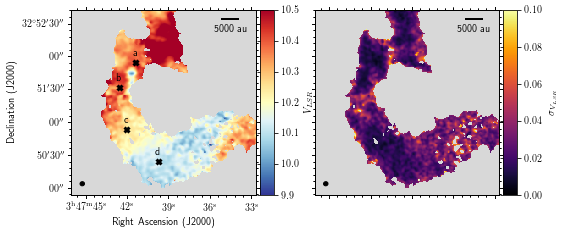

In [16]:
# velocity image with regions (take spectra of those regions too)
savefigure = True
fig = plt.figure(figsize=(8,8))
figname = figdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_1G_fitparams_v_LSR_wregions.pdf'

velocity = paramscube[1]
errvelocity = errcube[1]
velcube = [velocity, errvelocity]
headerplot = fits.getheader(tpeakfile + '.fits')
stretch = 'linear'
vmin = [9.9, 0]
vmax =[10.5, 0.1]
cmap = ['RdYlBu_r', 'inferno']
quantities = [r'$V_{LSR}$', r'$\sigma_{V_{LSR}}$']

for i in range(len(velcube)):
    ax0 = plot_aplpy_subfig(fits.PrimaryHDU(velcube[i], headerplot), fig, (1,2,i+1), stretch, \
                            vmin[i], vmax[i], cmap[i])
    ax0.colorbar.set_axis_label_text(quantities[i])
    ax0.recenter(56.9139998, 32.8550135, 0.0234465)
    if not i:
        ax0.show_regions(positionfile_hook)
    if i:
        ax0.tick_labels.hide()
        ax0.axis_labels.hide()
        
if savefigure:
    fig.savefig(figname, bbox_inches='tight', dpi=300)

#### Spectra with the 1 Gaussian fit

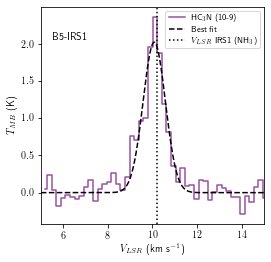

In [17]:
# fit results in B5-IRS1
savefigure = True

velinit = 5 * u.km/u.s
velend = 15 * u.km/u.s
label = 'B5-IRS1'
figname = figdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_spectrum_B5IRS1_wfit.pdf'

params = get_parameters_spectra(paramscube, position, cube_HC3N.header)
g1 = Gaussian1D(amplitude=params[0], mean=params[1], stddev=params[2])
vel = np.arange(velinit.value, velend.value, step=0.01)

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$V_{LSR}$ (km s$^{-1}$)')
ax.set_ylabel(r'$T_{MB}$ (K)')
spectrum = get_spectra(cube_HC3N, position, velinit, velend)
ax.plot(spectrum[0], spectrum[1], drawstyle='steps-mid', color=colorHC3N, label=r'HC$_3$N (10-9)')
ax.plot(vel, g1(vel), color='k', linestyle='dashed', label=r'Best fit')
ax.text(0.05, 0.85, label, horizontalalignment='left', transform=ax.transAxes, color='k', size=10)
ax.set_xlim([velinit.value, velend.value])
ax.axvline(10.21, color='k', linestyle='dotted', label=r'$V_{LSR}$ IRS1 (NH$_3$)')
ax.legend(fontsize=8)

if savefigure:
    fig.savefig(figname, bbox_inches='tight', dpi=300)

0.4861762853271439 -0.5184942311958254


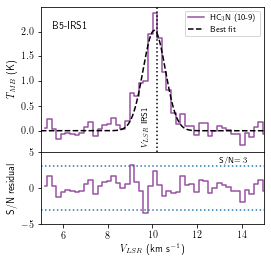

In [18]:
# fit with residuals
savefigure = True

rms = 0.15
velinit = 5 * u.km/u.s
velend = 15 * u.km/u.s
label = 'B5-IRS1'
figname = figdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_spectrum_B5IRS1_wfit_wres.pdf'

params = get_parameters_spectra(paramscube, position, cube_HC3N.header)
g1 = Gaussian1D(amplitude=params[0], mean=params[1], stddev=params[2])
vel = np.arange(velinit.value, velend.value, step=0.01)

fig, [ax, ax2] = plt.subplots(2, 1, figsize=(4,4), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

spectrum = get_spectra(cube_HC3N, position, velinit, velend)
ax.plot(spectrum[0], spectrum[1], drawstyle='steps-mid', color=colorHC3N, label=r'HC$_3$N (10-9)')
ax.plot(vel, g1(vel), color='k', linestyle='dashed', label=r'Best fit')
ax.text(0.05, 0.85, label, horizontalalignment='left', transform=ax.transAxes, color='k', size=10)
ax.set_xlim([velinit.value, velend.value])
ax.axvline(10.21, color='k', linestyle='dotted')
ax.annotate(r'$V_{LSR}$ IRS1', (0.45, 0.04), xycoords='axes fraction', size=8, rotation=90)

ax2.plot(spectrum[0], (spectrum[1].value-g1(spectrum[0].value))/rms, drawstyle='steps-mid', color=colorHC3N, label=r'HC$_3$N (10-9)')
ax.set_ylabel(r'$T_{MB}$ (K)')
ax2.set_ylabel('S/N residual')
ax2.set_xlabel(r'$V_{LSR}$ (km s$^{-1}$)')
ax2.set_ylim([-5, 5])
ax2.axhline(3, linestyle='dotted')
ax2.axhline(-3, linestyle='dotted')
ax.legend(fontsize=8)
ax2.annotate(r'S/N$=3$', (0.8, 0.85), xycoords='axes fraction', size=8)
fig.subplots_adjust(hspace=0)

if savefigure: 
    fig.savefig(figname, bbox_inches='tight', dpi=300)
    
print(np.amax(spectrum[1].value-g1(spectrum[0].value)), np.amin(spectrum[1].value-g1(spectrum[0].value)))

        Use another way of creating angles instead (e.g. a less ambiguous string like '-0h1m2.3s' instead. [astropy.coordinates.angles]
        Use another way of creating angles instead (e.g. a less ambiguous string like '-0d1m2.3s' instead. [astropy.coordinates.angles]


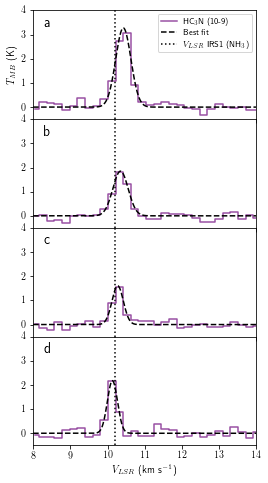

In [128]:
# fit along the hook
savefigure = True

positions_hook, labels_hook = getPositionFromRegions(positionfile_hook)

velinit = 8 * u.km/u.s
velend = 14 * u.km/u.s
label = 'B5-IRS1'
figname = figdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_spectra_wfit.pdf'
vel = np.arange(velinit.value, velend.value, step=0.01)

fig, axlist = plt.subplots(nrows=len(positions_hook), ncols=1, figsize=(4,8), sharex='all')
fig.subplots_adjust(hspace=0)
axlist[len(axlist)-1].set_xlabel(r'$V_{LSR}$ (km s$^{-1}$)')
axlist[0].set_ylabel(r'$T_{MB}$ (K)')

for ax, position, label in zip(axlist, positions_hook, labels_hook):
    params = get_parameters_spectra(paramscube, position, cube_HC3N.header)
    g1 = Gaussian1D(amplitude=params[0], mean=params[1], stddev=params[2])

    spectrum = get_spectra(cube_HC3N, position, velinit, velend)
    ax.plot(spectrum[0], spectrum[1], drawstyle='steps-mid', color=colorHC3N, label=r'HC$_3$N (10-9)')
    ax.plot(vel, g1(vel), color='k', linestyle='dashed', label=r'Best fit')
    ax.text(0.05, 0.85, label, horizontalalignment='left', transform=ax.transAxes, color='k', size=14)
    ax.set_xlim([velinit.value, velend.value])
    ax.axvline(10.21, color='k', linestyle='dotted', label=r'$V_{LSR}$ IRS1 (NH$_3$)')
    ax.set_ylim([-0.5,4])
axlist[0].legend(fontsize=8)
if savefigure:
    fig.savefig(figname, bbox_inches='tight', dpi=300)

### Results of the 2 Gaussian fit to HC$_3$N ($10-9$)

#### Spectrum at IRS1 after 2 Gaussian fit

        Use another way of creating angles instead (e.g. a less ambiguous string like '-0h1m2.3s' instead. [astropy.coordinates.angles]
        Use another way of creating angles instead (e.g. a less ambiguous string like '-0d1m2.3s' instead. [astropy.coordinates.angles]


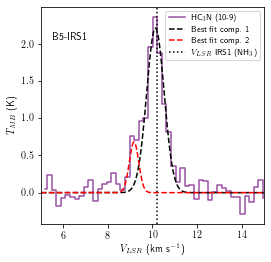

In [130]:
# fit results in B5-IRS1
savefigure = True

# positionfile = 'B5_NOEMA_30m/figures/B5_IRS1.reg'
# positions, labels = getPositionFromRegions(positionfile)
cube_HC3Ns = SpectralCube.read(smallimagefile+'.fits').with_spectral_unit(u.km/u.s)
positions, labels = getPositionFromRegions(positionfile)
paramsfile2g = fitfile2filtered
paramscube2g = fits.getdata(paramsfile2g)
position = positions[0]
velinit = 5 * u.km/u.s
velend = 15 * u.km/u.s
label = 'B5-IRS1'
figname = figdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_spectrum_B5IRS1_wfit2G.pdf'

params2g = get_parameters_spectra(paramscube2g, position, cube_HC3Ns.header)
g1 = Gaussian1D(amplitude=params2g[0], mean=params2g[1], stddev=params2g[2])
g2 = Gaussian1D(amplitude=params2g[3], mean=params2g[4], stddev=params2g[5])
vel = np.arange(velinit.value, velend.value, step=0.01)

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$V_{LSR}$ (km s$^{-1}$)')
ax.set_ylabel(r'$T_{MB}$ (K)')
spectrum = get_spectra(cube_HC3Ns, position, velinit, velend)
ax.plot(spectrum[0], spectrum[1], drawstyle='steps-mid', color=colorHC3N, label=r'HC$_3$N (10-9)')
ax.plot(vel, g1(vel), color='k', linestyle='dashed', label=r'Best fit comp. 1')
ax.plot(vel, g2(vel), color='r', linestyle='dashed', label=r'Best fit comp. 2')
ax.text(0.05, 0.85, label, horizontalalignment='left', transform=ax.transAxes, color='k', size=10)
ax.set_xlim([velinit.value, velend.value])
ax.axvline(10.21, color='k', linestyle='dotted', label=r'$V_{LSR}$ IRS1 (NH$_3$)')
ax.legend(fontsize=8)
if savefigure:
    fig.savefig(figname, bbox_inches='tight', dpi=300)

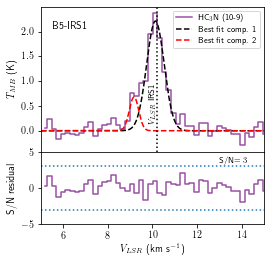

In [131]:
# check: 
savefigure = True
figname = figdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_spectrum_B5IRS1_wfit2G_wres.pdf'

fig, [ax, ax2] = plt.subplots(2, 1, figsize=(4,4), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
ax2.set_xlabel(r'$V_{LSR}$ (km s$^{-1}$)')
ax.set_ylabel(r'$T_{MB}$ (K)')
ax2.set_ylabel('S/N residual')
ax.plot(spectrum[0], spectrum[1], drawstyle='steps-mid', color=colorHC3N, label=r'HC$_3$N (10-9)')
ax.plot(vel, g1(vel), color='k', linestyle='dashed', label=r'Best fit comp. 1')
ax.plot(vel, g2(vel), color='r', linestyle='dashed', label=r'Best fit comp. 2')
ax.text(0.05, 0.85, label, horizontalalignment='left', transform=ax.transAxes, color='k', size=10)
ax.set_xlim([velinit.value, velend.value])
ax.axvline(10.21, color='k', linestyle='dotted')
ax.legend(fontsize=8)
ax2.axhline(-3, linestyle='dotted')
ax2.axhline(3, linestyle='dotted')
ax.annotate(r'$V_{LSR}$ IRS1', (0.48, 0.2), xycoords='axes fraction', size=8, rotation=90)


ax2.plot(spectrum[0], (spectrum[1].value - (g1(spectrum[0].value)+g2(spectrum[0].value)))/rmsKkmsHC3N, drawstyle='steps-mid', color=colorHC3N, label=r'HC$_3$N (10-9)')
ax2.set_ylim([-5, 5])
ax2.annotate(r'S/N$=3$', (0.8, 0.85), xycoords='axes fraction', size=8)
fig.subplots_adjust(hspace=0)
if savefigure:
    fig.savefig(figname, bbox_inches='tight', dpi=300)

#### Maps of the components

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cm.set_bad(color)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  cm.set_bad(color)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered

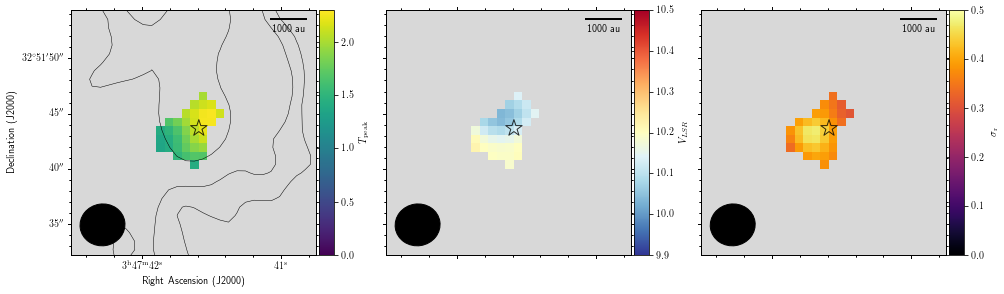

In [23]:
# strongest component
savefigure = True

fig = plt.figure(1, figsize=(16,8))
figname = figdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_B5zoom_2G_fitparams_filtered_resultscomp1.pdf'
# paramsfile2g = fitfile2filtered
# paramscube2g = fits.getdata(paramsfile2g)
cube_2g = fits.getdata(fitfile2filtered)
paramscube_2g = cube_2g[:3]

momentsmall = cube_HC3Ns.moment()
headerplot = momentsmall.header
stretch = 'linear'
vmin = [0, 9.9, 0]
vmax = [np.round(np.nanmax(paramscube_2g[0]), 1), 10.5, np.round(np.nanmax(paramscube_2g[2]), 1)]
cmap = ['viridis', 'RdYlBu_r', 'inferno']
quantities = [r'$T_{\mathrm{peak}}$', r'$V_{LSR}$', r'$\sigma_{\mathrm{r}}$']

for i in range(len(paramscube)):
    ax0 = plot_aplpy_subfig(fits.PrimaryHDU(paramscube_2g[i], headerplot), fig, (1,3,i+1), stretch, \
                            vmin[i], vmax[i], cmap[i], barsize=1000)
    ax0.colorbar.set_axis_label_text(quantities[i])
    ax0.recenter(56.9234601, 32.8620242, 0.0030777)
    ax0.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k', s=300)

    if i:
        ax0.tick_labels.hide()
        ax0.axis_labels.hide()
    elif not i:
        ax0.show_contour(mom0file, colors='k', levels=rmsKkmsHC3N*np.array([3,5,10]), linewidths=0.5)
        
if savefigure:
    fig.savefig(figname, bbox_inches='tight', dpi=300)

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cm.set_bad(color)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  cm.set_bad(color)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered

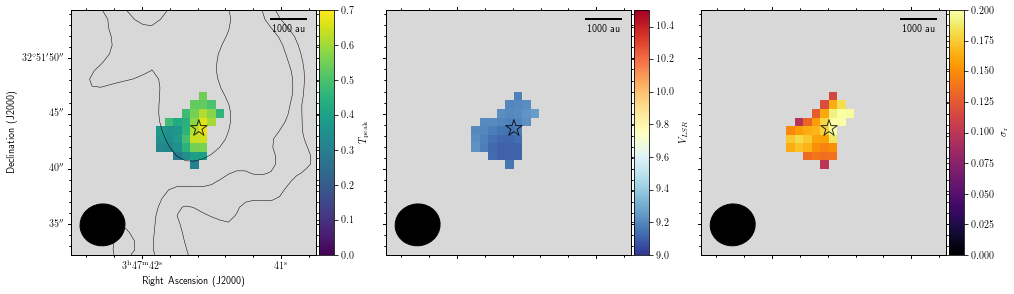

In [26]:
# Weakest component
savefigure = True
fig = plt.figure(1, figsize=(16,8))
figname = figdir + 'B5-NOEMA+30m-H3CN-10-9_cut_K_B5zoom_2G_fitparams_filtered_resultscomp2.pdf'

paramscube_2g = cube_2g[3:6]
headerplot = momentsmall.header
stretch = 'linear'
vmin = [0, 9.0, 0]
vmax = [np.round(np.nanmax(paramscube_2g[0]), 1), 10.5, np.round(np.nanmax(paramscube_2g[2]), 1)]
cmap = ['viridis', 'RdYlBu_r', 'inferno']
quantities = [r'$T_{\mathrm{peak}}$', r'$V_{LSR}$', r'$\sigma_{\mathrm{r}}$']

for i in range(len(paramscube)):
    ax0 = plot_aplpy_subfig(fits.PrimaryHDU(paramscube_2g[i], headerplot), fig, (1,3,i+1), stretch, \
                            vmin[i], vmax[i], cmap[i], barsize=1000)
    ax0.colorbar.set_axis_label_text(quantities[i])
    ax0.recenter(56.9234601, 32.8620242, 0.0030777)
    ax0.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k', s=300)
    
    if i:
        ax0.tick_labels.hide()
        ax0.axis_labels.hide()
    elif not i:
        ax0.show_contour(mom0file, colors='k', levels=rmsKkmsHC3N*np.array([3,5,10]), linewidths=0.5)
        
if savefigure:
    fig.savefig(figname, bbox_inches='tight', dpi=300)

### Line ratio maps and column density

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cm.set_bad(color)


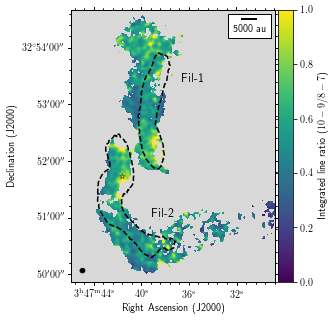

In [30]:
savefigure = True
fig = plt.figure(figsize=(5,5))
figname = figdir + 'B5_NOEMA_30m_10-9_over_8-7.pdf'

gc = plot_aplpy_subfig(ratiomapfile, fig, (1,1,1), 'linear', 0, 1, 'viridis', showframeScalebar=True)

# filament outline from NH3(1,1)
gc.show_contour(nh3mom0file, colors='k', linestyles='dashed', levels=nh3mom0levels, zorder=34)
gc.add_label(0.6, 0.75, 'Fil-1', relative=True, color='k', size=12)
gc.add_label(0.45, 0.25, 'Fil-2', relative=True, color='k', size=12)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.5, layer='lay_yso',  facecolor='None', edgecolor='k')
gc.recenter(56.9055921,32.8711272,width=0.06,height=0.08)
gc.colorbar.set_axis_label_text(r'Integrated line ratio ($10-9/8-7$)')


if savefigure:
    fig.savefig(figname, bbox_inches='tight', dpi=300)

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cm.set_bad(color)


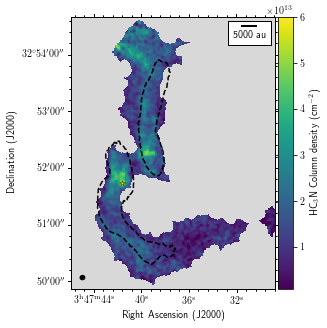

In [22]:
savefigure = True
fig = plt.figure(figsize=(5,5))
figname = figdir + 'B5_NOEMA_30m_10-9_Ntot.pdf'

gc = plot_aplpy_subfig(Ntotmapfile, fig, (1,1,1), 'linear', 1e12, 6e13, 'viridis', showframeScalebar=True)

# filament outline from NH3(1,1)
gc.show_contour(nh3mom0file, colors='k', linestyles='dashed', levels=nh3mom0levels, zorder=34)
# gc.add_label(0.6, 0.75, 'Fil-1', relative=True, color='k', size=12)
# gc.add_label(0.45, 0.25, 'Fil-2', relative=True, color='k', size=12)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.5, layer='lay_yso',  facecolor='None', edgecolor='k')
gc.recenter(56.9055921,32.8711272,width=0.06,height=0.08)
gc.colorbar.set_axis_label_text(r'HC$_3$N Column density (cm$^{-2}$)')


if savefigure:
    fig.savefig(figname, bbox_inches='tight', dpi=300)

## ALMA observations: H$_2$CO and C$^{18}$O

### Filenames

In [141]:
filediralma = 'B5_IRS1_ALMA/'
h2cocubefile = filediralma + 'cleaned_images/B5IRS1_H2COa_robust05_multi_3_cut_pbcor.fits'
h2cocubefileK = filediralma + 'cleaned_images/B5IRS1_H2COa_robust05_multi_3_cut_pbcor_K.fits'
h2comom0file = filediralma + 'cleaned_images/B5IRS1_H2COa_robust05_multi_3_cut_mom0.fits'
h2comom0bluefile = filediralma + 'cleaned_images/B5IRS1_H2COa_robust05_multi_3_cut_mom0_blueenv.fits'
h2comom1file = filediralma + 'cleaned_images/B5IRS1_H2COa_robust05_multi_3_cut_mom1.fits'
rms_mom0_h2co = 0.005714 # Jy/b km/s
figurefolder = 'figures/'
freq_H2CO = 218.222195 * u.GHz
regions_alma_spectra = filediralma + 'region_plot_H2CO_2.reg'

# Filenames: resulting components of 1, 2, and 3 Gaussian fit to H2CO, both masked and not masked combined
h2cofitfile1G = filediralma + 'gaussfit_H2CO/analysis_central_chans_masked/B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_1G_fitparams_total_aicres.fits'
h2cofitfile2G = filediralma + 'gaussfit_H2CO/analysis_central_chans_masked/B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_2G_fitparams_total_aicres.fits'
h2cofitfile3G = filediralma + 'gaussfit_H2CO/analysis_central_chans_masked/B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_3G_fitparams_total_aicres.fits'
h2cofitparamsmissing = filediralma + 'gaussfit_H2CO/analysis_central_chans_masked/B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_paramsmissing.fits'
h2concomponentfile = filediralma + 'gaussfit_H2CO/analysis_central_chans_masked/B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_total_ncomponents.fits'

h2cofitfile1G_allchans = filediralma + 'gaussfit_H2CO/all_chans/B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_1G_fitparams_2_filtered_Vlsr'

# DBSCAN results
dbscanresfile = filediralma + 'gaussfit_H2CO/analysis_central_chans_masked/DBSCAN_results.npy'
h2cotpeakbluefile = filediralma + 'gaussfit_H2CO/analysis_central_chans_masked/components_blueshifted_envelope_Tpeak.fits'
h2cotpeakredfile = filediralma + 'gaussfit_H2CO/analysis_central_chans_masked/components_redshifted_envelope_Tpeak.fits'
h2coblueparamsfile = filediralma + 'gaussfit_H2CO/analysis_central_chans_masked/components_blueshifted_envelope.fits'
h2cobluevlsrfile = filediralma + 'gaussfit_H2CO/analysis_central_chans_masked/components_blueshifted_envelope_vlsr.fits'
h2coredparamsfile = filediralma + 'gaussfit_H2CO/analysis_central_chans_masked/components_redshifted_envelope.fits'
h2coredvlsrfile = filediralma + 'gaussfit_H2CO/analysis_central_chans_masked/components_redshifted_envelope_vlsr.fits'
spine_coordinates_file = filediralma + 'gaussfit_H2CO/analysis_central_chans_masked/components_blueshifted_envelope_spine_coords_vel.npy'
kde_blue_file = filediralma + 'gaussfit_H2CO/analysis_central_chans_masked/components_blueshifted_envelope_kde.npy'
kde_blue_sigma_file = filediralma + 'gaussfit_H2CO/analysis_central_chans_masked/components_blueshifted_envelope_kde_sigma_nt.npy'
kde_red_file = filediralma + 'gaussfit_H2CO/analysis_central_chans_masked/components_redshifted_envelope_kde.npy'
kde_red_sigma_file = filediralma + 'gaussfit_H2CO/analysis_central_chans_masked/components_redshifted_envelope_kde_sigma_nt.npy'
sl_model_blue_init_result_file = filediralma + 'gaussfit_H2CO/analysis_central_chans_masked/components_blueshifted_envelope_sl_model_res.npy'
sl_model_red_init_result_file = filediralma + 'gaussfit_H2CO/analysis_central_chans_masked/components_redshifted_envelope_sl_model_res.npy'


c18ocubefile = filediralma + 'cleaned_images/B5IRS1_C18O_robust05_multi.fits'
c18ocubefileK = filediralma + 'cleaned_images/B5IRS1_C18O_robust05_multi_K.fits'
c18omom0file = filediralma + 'cleaned_images/B5IRS1_C18O_robust05_multi_mom0.fits'
c18omom1file = filediralma + 'cleaned_images/B5IRS1_C18O_robust05_multi_mom1.fits'
regions_alma_C18O_spectra = 'B5_IRS1_ALMA/region_plot_C18O.reg'
rms_mom0_c18o = 0.007 # Jy/b km/s
freq_C18O = 219.560354 * u.GHz

### Moment 0 Maps of H$_2$CO ($3_{0, 3} - 2_{0, 2}$)

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("inferno").copy()
  cm.set_bad(color)


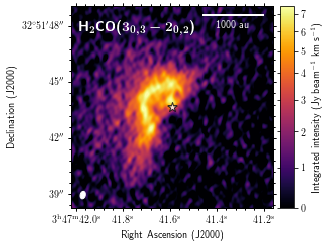

In [34]:
# moment 0 with inferno for streamer gallery
savefigure = True
title = r'\textbf{H\boldmath$_2$CO($3_{0,3}-2_{0,2}$)}'
fig = plt.figure(figsize=(4,4))
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_cut_mom0_blueenv_inferno_wzoom.pdf'
gc = plot_aplpy_subfig(h2comom0bluefile, fig, (1,1,1), 'arcsinh', 0, 7.5, 'inferno', vmid=3, label_col='w',barsize=1000)
gc.recenter(ra_yso, dec_yso, 0.0015)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='w', edgecolor='k', s=100)
gc.show_circles(ra_yso, dec_yso, (primary_beam_alma(freq_H2CO)/2).to(u.deg).value, color='w')
gc.beam.set_color('w')
gc.colorbar.set_axis_label_text(r'Integrated intensity (Jy beam$^{-1}$ km s$^{-1}$)')
gc.tick_labels.set_xformat('hh:mm:ss.s')
gc.add_label(0.62,0.9, title, color='w',
              relative=True, horizontalalignment='right', 
              size=14)
gc.colorbar.set_pad(0.1)
if savefigure:
    fig.savefig(figname, bbox_inches='tight')

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cm.set_bad(color)


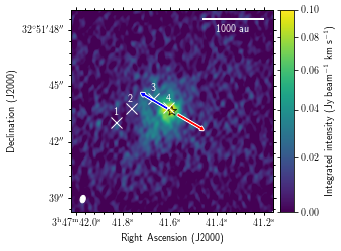

In [63]:
# moment 0 with regions and outflow
savefigure = True

fig = plt.figure(figsize=(4,4))
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_cut_mom0_regions_woutflow.pdf' #_regions
gc = plot_aplpy_subfig(h2comom0file, fig, (1,1,1), 'arcsinh', 0, 0.1, 'viridis', vmid=0.05, label_col='w',barsize=1000)
gc.recenter(ra_yso, dec_yso, 0.0015)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k', s=100)
gc.show_circles(ra_yso, dec_yso, (primary_beam_alma(freq_H2CO)/2).to(u.deg).value, color='w')
gc.beam.set_color('w')
gc.colorbar.set_axis_label_text(r'Integrated intensity (Jy beam$^{-1}$ km s$^{-1}$)')
gc.tick_labels.set_xformat('hh:mm:ss.s')
gc.show_regions(regions_alma_spectra)

arrowlength = 0.0005
pa = (157.1-180) * 180/ np.pi

gc.show_arrows(ra_yso+0.0001, dec_yso+0.00005,arrowlength*np.sin(pa), arrowlength*np.cos(pa), color='w', zorder=100, linewidth=3)
gc.show_arrows(ra_yso+0.0001, dec_yso+0.00005,arrowlength*np.sin(pa), arrowlength*np.cos(pa), color='b', zorder=100)
gc.show_arrows(ra_yso-0.0001, dec_yso-0.00005, -arrowlength*np.sin(pa), -arrowlength*np.cos(pa), color='w', linewidth=3)
gc.show_arrows(ra_yso-0.0001, dec_yso-0.00005, -arrowlength*np.sin(pa), -arrowlength*np.cos(pa), color='r', zorder=100)
gc.colorbar.set_pad(0.1)
if savefigure:
    fig.savefig(figname, bbox_inches='tight')

### Channel maps of H$_2$CO ($3_{0, 3} - 2_{0, 2}$)

In [36]:
if not os.path.exists(h2cocubefileK):
    cube_H2CO = SpectralCube.read(h2cocubefile).with_spectral_unit(u.km/u.s)
    cube_H2CO.allow_huge_operations=True
    cube_H2CO = cube_H2CO.to(u.K)
    cube_H2CO.hdu.writeto(h2cocubefileK)
else:
    cube_H2CO = SpectralCube.read(h2cocubefileK).with_spectral_unit(u.km/u.s)
wcssky = WCS(cube_H2CO.header).celestial    
ra_yso_pix, dec_yso_pix = wcssky.wcs_world2pix(ra_yso, dec_yso, 0)
ra_yso_pix, dec_yso_pix = float(ra_yso_pix), float(dec_yso_pix)
pbradius = (primary_beam_alma(freq_H2CO)/2).to(u.deg).value / cube_H2CO.header['CDELT2']

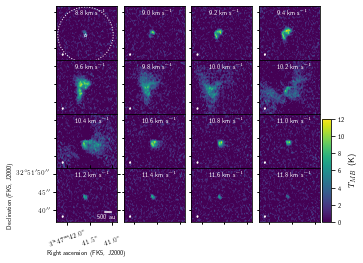

In [41]:
savefigure = True

velinit = 8.8 * u.km/u.s
deltav = 0.2 * u.km/u.s
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_chanmap_{0}_{1}.pdf'.format(velinit.value,deltav.value)
nrows = 4
ncols = 4
vmax = 12
vmin = 0
velocity_array = cube_H2CO.spectral_axis.value
velocity_sample = np.arange(velinit.value, velinit.value+(nrows*ncols*deltav.value), deltav.value) 
bmaj, bmin = np.array([cube_H2CO.header['BMAJ'], cube_H2CO.header['BMIN']])/np.abs(cube_H2CO.header['CDELT2'])
bpa = cube_H2CO.header['BPA']-90
scalebarsize = 500
scalebarpix = int((scalebarsize / dist_B5.value) / 3600 / cube_H2CO.header['CDELT2'])


fig, axlist = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(6,4), subplot_kw={'projection': wcssky})
axlist = axlist.flatten()
for i, ax in enumerate(axlist):
    indexvel = np.argmin(np.abs(velocity_array-velocity_sample[i]))
    planevel = cube_H2CO.unmasked_data[indexvel, :, :]
    im = ax.imshow(planevel, vmin = vmin, vmax=vmax)
    ax.annotate(str(np.round(velocity_sample[i], 2))+r' km s$^{-1}$', (0.3, 0.85), xycoords='axes fraction', color='w', size=6)
    beam = Ellipse((32, 29), bmaj, bmin, angle=bpa, ec = 'w', fc='w')
    ax.add_patch(beam)
    # ax.scatter(ra_yso_pix, dec_yso_pix, marker='*', facecolor=None, edgecolor='w', s=15, linewidth=0.5, alpha=0.8)
    
    if i == 0:
        pb = Circle((ra_yso_pix, dec_yso_pix), pbradius, ec = 'w', fc='None', ls=':')
        ax.add_patch(pb)
        ax.scatter(ra_yso_pix, dec_yso_pix, marker='*', facecolor=None, edgecolor='w', s=15, linewidth=0.5, alpha=0.8)    
        
    if not i == ncols*nrows - ncols:
        ax.tick_params(axis='x', which='both', bottom=True, labelbottom=False, length=2)
        ax.tick_params(axis='y', which='both', left=True, labelleft=False, length=2)
    else:
        # ax.set_xlabel('Right ascension (FK5, J2000)')
        # ax.set_ylabel('Declination (FK5, J2000)')
        lon = ax.coords[0]
        lat = ax.coords[1]
        lon.set_axislabel('Right ascension (FK5, J2000)', size=6)
        lat.set_axislabel('Declination (FK5, J2000)', size=6)
        lon.set_ticklabel(rotation=20,pad=15,ha='right', size=6)
        lat.set_ticklabel(size=6)
        ax.plot([250, 250+scalebarpix], [50, 50], color='w', lw=1.5)
        ax.annotate(str(scalebarsize)+' au', (0.66, 0.07), xycoords='axes fraction', color='w', size=6)
        
fig.tight_layout(pad=0)
fig.subplots_adjust(left=0.2, right=0.98, bottom=0.15, top=0.9, hspace = 0, wspace=-0.5)
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.36])
cbar = fig.colorbar(im, cax=cbar_ax, ticks=[0,2,4,6,8,10,12])
cbar.set_label(label=r'$T_{MB}$ (K)', size=8)
cbar_ax.set_yticklabels(['0', '2', '4', '6', '8', '10', '12'])
cbar_ax.tick_params(labelsize=6)
# fig.subplots_adjust(hspace = 0, wspace=-0.5) 

if savefigure:
    fig.savefig(figname, dpi=300, bbox_inches='tight')
    

### Spectra of selected regions for H$_2$CO ($3_{0, 3} - 2_{0, 2}$)

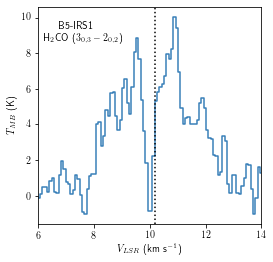

In [137]:
#spectra at the location of the protostar
colorH2CO = '#377eb8' #blue
savefig = True

position = [ra_yso, dec_yso]
velinit = 6 * u.km/u.s
velend = 14 * u.km/u.s
label = r'B5-IRS1 \\ H$_2$CO ($3_{0,3} - 2_{0,2}$)'
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_spectra_IRS1.pdf'

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$V_{LSR}$ (km s$^{-1}$)')
ax.set_ylabel(r'$T_{MB}$ (K)')
spectrum = get_spectra(cube_H2CO, position, velinit, velend)
ax.plot(spectrum[0], spectrum[1], drawstyle='steps-mid', color=colorH2CO)
ax.text(0.02, 0.9, label, horizontalalignment='left', transform=ax.transAxes, color='k', size=10)
ax.set_xlim([velinit.value, velend.value])
ax.axvline(10.2, color='k', linestyle='dotted', label=r'$V_{LSR}$ IRS1 (NH$_3$)')
if savefig:
    fig.savefig(figname, bbox_inches='tight')

        Use another way of creating angles instead (e.g. a less ambiguous string like '-0h1m2.3s' instead. [astropy.coordinates.angles]
        Use another way of creating angles instead (e.g. a less ambiguous string like '-0d1m2.3s' instead. [astropy.coordinates.angles]


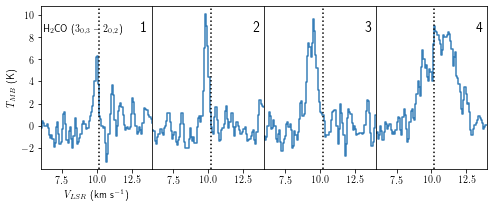

In [64]:
#spectra at selected locations in the streamer and pseudodisk
savefig = False

positions, labels = getPositionFromRegions(regions_alma_spectra)
velinit = 6 * u.km/u.s
velend = 14 * u.km/u.s
label = r'H$_2$CO ($3_{0,3} - 2_{0,2}$)'
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_spectra_selected_regions.pdf'

fig, axes = plt.subplots(ncols=4, nrows=1, sharex=True, sharey=True, figsize=(8,3))
axes[0].set_xlabel(r'$V_{LSR}$ (km s$^{-1}$)')
axes[0].set_ylabel(r'$T_{MB}$ (K)')

for i in range(len(axes)):
    position = positions[i]
    spectrum = get_spectra(cube_H2CO, position, velinit, velend)
    ax = axes[i]
    ax.plot(spectrum[0], spectrum[1], drawstyle='steps-mid', color=colorH2CO)
    ax.text(0.9, 0.85, labels[i], horizontalalignment='left', transform=ax.transAxes, color='k', size=14)
    ax.set_xlim([velinit.value, velend.value])
    ax.axvline(10.2, color='k', linestyle='dotted', label=r'$V_{LSR}$ IRS1 (NH$_3$)')
    if i: ax.tick_params(axis='y', which='both', left=False)
fig.subplots_adjust(wspace=0)
axes[0].text(0.02, 0.85, label, horizontalalignment='left', transform=axes[0].transAxes, color='k', size=10)
if savefig:
    fig.savefig(figname, bbox_inches='tight')

### Results of the multi-Gaussian fit to H$_2$CO ($3_{0, 3} - 2_{0, 2}$)

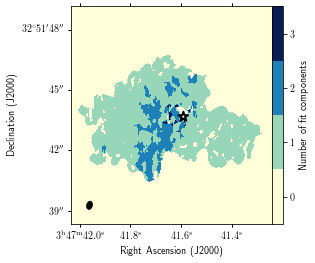

In [66]:
# plot the number of components 
savefigure = True
figname = figurefolder + 'B5IRS1_H2COa_total_aicres_ncomponents.pdf'

data = fits.getdata(h2concomponentfile)
data[np.where(np.isnan(data))] = 0
header = fits.getheader(h2concomponentfile)
wcs = WCS(header)
bmaj, bmin = np.array([header['BMAJ'], header['BMIN']])/np.abs(header['CDELT2'])
bpa = header['BPA']-90

cmap1 = plt.cm.get_cmap("YlGnBu", 4).copy()
rapix, decpix = wcs.wcs_world2pix([ra_yso], [dec_yso], 0)

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111, projection=wcs)
sc1 = ax.imshow(data, cmap=cmap1, vmin=-0.5, vmax=3.5) # red
cax = plt.colorbar(sc1, ax=ax, label='Number of fit components', ticks=np.arange(4), pad=0)
beam = Ellipse((62, 49), bmaj, bmin, angle=bpa, ec = 'k', fc='k')
ax.scatter(rapix, decpix, marker='*', s=100, facecolor='none', edgecolor='k', linewidth=2)
ax.add_patch(beam)
ax.set_xlim([45,230])
ax.set_ylim([32,232])
ax.set_xlabel(r'Right Ascension (J2000)')
ax.set_ylabel(r'Declination (J2000)')

if savefigure:
    fig.savefig(figname, bbox_inches='tight')

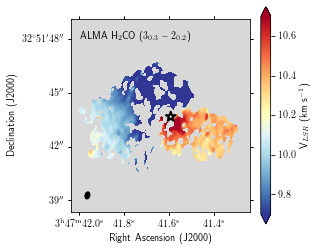

In [68]:
# AIC evaluated 1 Gaussian fit v_lsr (to compare with HC3N and NH3)

savefigure = True
figname = figurefolder + 'B5IRS1_H2COa_1G_fitparams_total_aicres_Vlsr'

cube1g = fits.getdata(h2cofitfile1G)
paramscube1g = cube1g[1]
header = fits.getheader(h2cofitparamsmissing)
stretch = 'linear'
vmin = 10.2-0.5
vmax = 10.2+0.5
cmap = 'RdYlBu_r'
quantities = r'V$_{LSR}$ (km s$^{-1}$)'

data = paramscube1g
# header = fits.getheader(h2concomponentfile)
wcs = WCS(header)
bmaj, bmin = np.array([header['BMAJ'], header['BMIN']])/np.abs(header['CDELT2'])
bpa = header['BPA']-90

cmap1 = plt.cm.get_cmap(cmap).copy()
cmap1.set_bad(color='0.85')
rapix, decpix = wcs.wcs_world2pix([ra_yso], [dec_yso], 0)

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection=wcs)
sc1 = ax.imshow(data, cmap=cmap1, vmin=vmin, vmax=vmax) # red
cax = plt.colorbar(sc1, ax=ax, label=quantities,extend='both')
beam = Ellipse((62, 49), bmaj, bmin, angle=bpa, ec = 'k', fc='k')
ax.scatter(rapix, decpix, marker='*', s=100, facecolor='none', edgecolor='k', linewidth=2)
ax.add_patch(beam)
ax.set_xlim([45,230])
ax.set_ylim([32,232])
ax.set_xlabel(r'Right Ascension (J2000)')
ax.set_ylabel(r'Declination (J2000)')
ax.annotate(r'ALMA H$_2$CO ($3_{0,3}-2_{0,2}$)', (0.05, 0.9), xycoords='axes fraction',color='k', size=10)

if savefigure:
    fig.savefig(figname+'.pdf', bbox_inches='tight', dpi=300)
    

### Results of the clustering of multi-Gaussian fit

#### Visualization of DBSCAN results

/tmp/ipykernel_36791/3942295453.py:18: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("YlGnBu_r").copy()
  cmap3.set_bad('0.85', 1.)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/ho

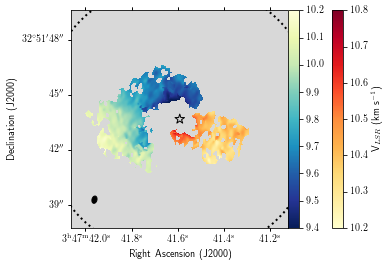

In [72]:
# test to plot the v_lsr together
savefigure = True
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_envelopes_vlsr.pdf'

data1 = fits.getdata(h2coredvlsrfile)
header1 = fits.getheader(h2coredvlsrfile)
data2 = fits.getdata(h2cobluevlsrfile)
wcs = WCS(header1)
bmaj, bmin = np.array([header1['BMAJ'], header1['BMIN']])/np.abs(header1['CDELT2'])
bpa = header1['BPA']-90
pbradius = (primary_beam_alma(freq_H2CO)/2).to(u.deg).value / header1['CDELT2']

cmap1 = plt.cm.get_cmap("YlOrRd").copy()
cmap1.set_bad('white', 0.)
cmap2 = plt.cm.get_cmap("YlGnBu_r").copy()
cmap2.set_bad('white', 0.)
cmap3 = plt.cm.YlGnBu_r
cmap3.set_bad('0.85', 1.)
rapix, decpix = wcs.wcs_world2pix([ra_yso], [dec_yso], 0)

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111, projection=wcs)
sc1 = ax.imshow(data1, vmin=10.2, vmax=10.2+0.6, cmap=cmap1, zorder=10) # red
sc2 = ax.imshow(data2, vmin=10.2-0.8, vmax=10.2, cmap=cmap2, zorder=10) # blue
ax.imshow(np.ones(np.shape(data1))*np.nan, cmap=cmap3, zorder=0)
plt.colorbar(sc1, ax=ax, label=r'V$_{LSR}$ (km s$^{-1}$)', pad=0.002)
plt.colorbar(sc2, ax=ax, pad=0)
ax.scatter(rapix, decpix, marker='*', s=100, facecolor='none', edgecolor='k')
beam = Ellipse((62, 49), bmaj, bmin, angle=bpa, ec = 'k', fc='k')
pb = Circle((rapix, decpix), pbradius, ec = 'k', fc='None', ls=':', lw=2)
ax.add_patch(pb)
ax.add_patch(beam)
ax.set_xlim([rapix-110,rapix+110])
ax.set_ylim([decpix-110,decpix+110])
ax.set_xlabel(r'Right Ascension (J2000)')
ax.set_ylabel(r'Declination (J2000)')

if savefigure:
    fig.savefig(figname, dpi=300,bbox_inches='tight')

In [85]:
from mpl_toolkits.mplot3d import axes3d
dbscan_results = np.load(dbscanresfile)
labels = dbscan_results[:, 3]
features = dbscan_results[:, 0:3]
unique_labels = set(labels)
colors_dbscan = ['#377eb8', '#e41a1c', '#4daf4a', '#984ea3', '#ff7f00']

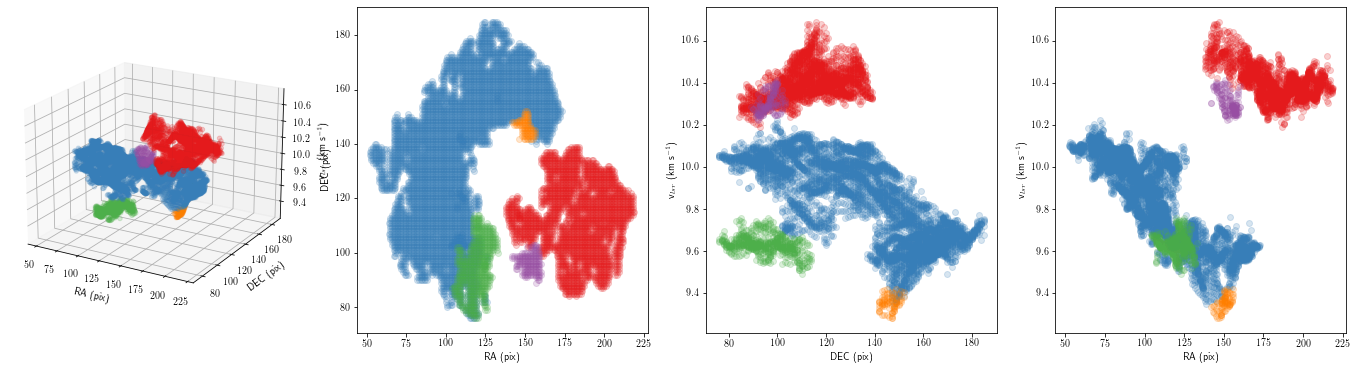

In [95]:
# 3D view of the results of the clustering algorithm
# we know that the blue label is 0 and the red label is 1

savefigure = True
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_dbscan_results_vis.pdf'
fig = plt.figure(figsize=(24,6))

azim = -60
el = 20
ax = fig.add_subplot(1, 4, 1, projection='3d')
ax.set_xlabel('RA (pix)')
ax.set_ylabel('DEC (pix)')
ax.set_zlabel(r'v$_{lsr}$ (km s$^{-1}$)')

ax2 = fig.add_subplot(142)
ax2.set_xlabel('RA (pix)')
ax2.set_ylabel('DEC (pix)')
ax3 = fig.add_subplot(143)
ax3.set_ylabel(r'v$_{lsr}$ (km s$^{-1}$)')
ax3.set_xlabel('DEC (pix)')
ax4 = fig.add_subplot(144)
ax4.set_ylabel(r'v$_{lsr}$ (km s$^{-1}$)')
ax4.set_xlabel('RA (pix)')
for k, col in zip(unique_labels, colors_dbscan):
    if k == -1:
        continue

    class_member_mask = labels == k

    xy = features[class_member_mask]
    ax.scatter(xy[:,0], xy[:,1], xy[:,2], color=col, alpha=0.2, label=k)
    ax2.scatter(xy[:,0], xy[:,1], color=col, alpha=0.2, label=k)
    ax3.scatter(xy[:,1], xy[:,2], color=col, alpha=0.2, label=k)
    ax4.scatter(xy[:,0], xy[:,2], color=col, alpha=0.2, label=k)

    
ax.view_init(azim=azim, elev=el)
if savefigure:
    fig.savefig(figname, dpi=300,bbox_inches='tight')    

#### Analysis: Kernel density estimate of the DBSCAN main components' $\sigma_{V}$


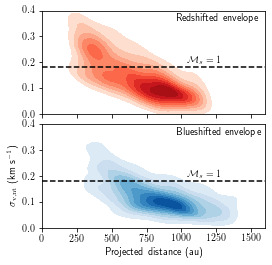

In [96]:
# plot of  the kde of the sigma_v for the blue and red envelopes together
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_envelopes_kde_sigma.pdf'
savefigure = True

xx_sigma_blue, yy_sigma_blue, zz_sigma_blue = np.load(kde_blue_sigma_file)
xx_sigma_red, yy_sigma_red, zz_sigma_red = np.load(kde_red_sigma_file)
vmin, vmax = 0, 0.4
xmin, xmax = 0, 1600
soundspeed = 0.18

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(4,4))

axes[0].contourf(xx_sigma_red, yy_sigma_red, zz_sigma_red, cmap='Reds', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
axes[1].contourf(xx_sigma_blue, yy_sigma_blue, zz_sigma_blue, cmap='Blues', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
axes[0].axhline(soundspeed, color='k', linestyle='dashed')
axes[1].axhline(soundspeed, color='k', linestyle='dashed')
axes[0].annotate(r'$\mathcal{M}_{s}=1$', (0.65, 0.5), xycoords='axes fraction', size=10)
axes[0].annotate('Redshifted envelope', (0.6, 0.9), xycoords='axes fraction', size=10)
axes[1].annotate(r'$\mathcal{M}_{s}=1$', (0.65, 0.5), xycoords='axes fraction', size=10)
axes[1].annotate('Blueshifted envelope', (0.6, 0.9), xycoords='axes fraction', size=10)
axes[0].set_ylim([vmin,vmax])
axes[0].set_xlim([xmin,xmax])

axes[1].set_xlabel('Projected distance (au)')
axes[1].set_ylabel(r"$\sigma_{\mathrm{v, nt}}$ (km s$^{-1}$)")
plt.subplots_adjust(hspace=0.1)
if savefigure:
    fig.savefig(figname, bbox_inches='tight')

### Streamline model applied to DBSCAN results

In [98]:
fil0_ra_blue, fil0_dec_blue, dsky0_blue, velo0_blue = np.load(sl_model_blue_init_result_file)
fil0_ra_red, fil0_dec_red, dsky0_red, velo0_red = np.load(sl_model_red_init_result_file)
# Vlsr KDEs
xx_blue, yy_blue, zz_blue = np.load(kde_blue_file)
xx_red, yy_red, zz_red = np.load(kde_red_file)

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cm.set_bad(color)


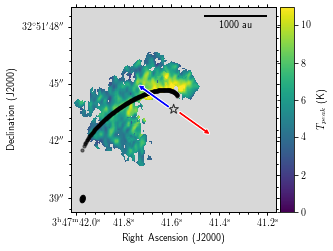

In [99]:
# plot of the tpeak with an outflow contour and the 
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_blueshifted_env_woutflow_wmodel.pdf'
savefigure = True

fig = plt.figure(figsize=(4,4))
gc = plot_aplpy_subfig(h2cotpeakbluefile, fig, (1,1,1), 'linear', 0, 11, 'viridis', label_col='k',barsize=1000)
gc.recenter(ra_yso, dec_yso, 0.0015)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k', s=100)
gc.tick_labels.set_xformat('hh:mm:ss.s')
gc.colorbar.set_axis_label_text(r'$T_{peak}$ (K)')
gc.show_arrows(ra_yso+0.0001, dec_yso+0.000045, 0.0005, 0.0003, color='w', zorder=100, linewidth=3)
gc.show_arrows(ra_yso+0.0001, dec_yso+0.000045, 0.0005, 0.0003, color='b', zorder=100)
gc.show_arrows(ra_yso-0.0001, dec_yso-0.000045, -0.0005, -0.0003, color='w', linewidth=3)
gc.show_arrows(ra_yso-0.0001, dec_yso-0.000045, -0.0005, -0.0003, color='r', zorder=100)
# gc.show_markers(spine_coords_ra, spine_coords_dec, marker='.', alpha=0.5, facecolor='b', edgecolor=None, s=80)
gc.show_markers(fil0_ra_blue, fil0_dec_blue, marker='.', alpha=0.5, facecolor='k', edgecolor=None, s=40)
if savefigure:
    fig.savefig(figname, bbox_inches='tight')

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("inferno").copy()
  cm.set_bad(color)


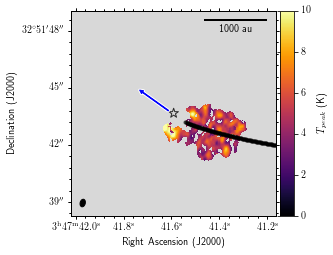

In [101]:
# plot of the tpeak with an outflow contour for the redshifted component
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_redshifted_env_woutflow_wmodel.pdf'
savefigure = True

fig = plt.figure(figsize=(4,4))
gc = plot_aplpy_subfig(h2cotpeakredfile, fig, (1,1,1), 'linear', 0, 10, 'inferno', label_col='k',barsize=1000)
gc.recenter(ra_yso, dec_yso, 0.0015)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k', s=100)
gc.tick_labels.set_xformat('hh:mm:ss.s')
gc.colorbar.set_axis_label_text(r'$T_{peak}$ (K)')
gc.show_arrows(ra_yso+0.0001, dec_yso+0.000045, 0.0005, 0.0003, color='w', zorder=100, linewidth=3)
gc.show_arrows(ra_yso+0.0001, dec_yso+0.000045, 0.0005, 0.0003, color='b', zorder=100)
# gc.show_arrows(ra_yso-0.0001, dec_yso-0.000045, -0.0005, -0.0003, color='w', linewidth=3)
# gc.show_arrows(ra_yso-0.0001, dec_yso-0.000045, -0.0005, -0.0003, color='r', zorder=100)

gc.show_markers(fil0_ra_red, fil0_dec_red, marker='.', alpha=0.5, facecolor='k', edgecolor=None, s=40)
if savefigure:
    fig.savefig(figname, bbox_inches='tight')

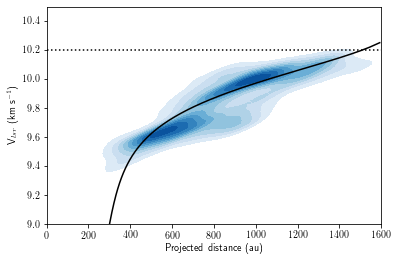

In [106]:
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_blueshifted_env_kde_wslmodel.pdf'
savefigure = False
velmin, velmax = 9, 10.5
xmin, xmax = 0, 1600
velobject = 10.2

fig = plt.figure(figsize=(6,4))
ax2 = fig.add_subplot(111)
ax2.set_xlabel('Projected distance (au)')
ax2.set_ylabel(r"V$_{lsr}$ (km s$^{-1}$)")
ax2.contourf(xx_blue, yy_blue, zz_blue, cmap='Blues', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
ax2.axhline(velobject, color='k', ls=':')
ax2.set_ylim([velmin,velmax])
ax2.set_xlim([xmin,xmax])
# ax2.plot(deltar_proj, spine_vel, 'b.')
ax2.plot(dsky0_blue, velo0_blue, 'k-')
if savefigure:
    fig.savefig(figname, bbox_inches='tight')

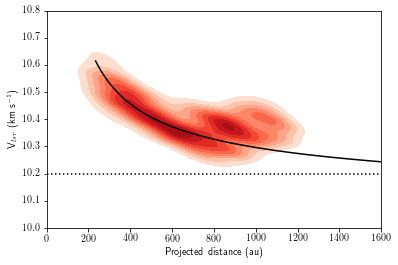

In [105]:
figname = figurefolder + 'B5IRS1_H2COa_robust05_multi_3_redshifted_env_kde_wslmodel.pdf'
savefigure = True
velmin, velmax = 10, 10.8
xmin, xmax = 0, 1600
velobject = 10.2

fig = plt.figure(figsize=(6,4))
ax2 = fig.add_subplot(111)
ax2.set_xlabel('Projected distance (au)')
ax2.set_ylabel(r"V$_{lsr}$ (km s$^{-1}$)")
ax2.contourf(xx_red, yy_red, zz_red, cmap='Reds', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
ax2.axhline(velobject, color='k', ls=':')
ax2.set_ylim([velmin,velmax])
ax2.set_xlim([xmin,xmax])
ax2.plot(dsky0_red, velo0_red, 'k-')
if savefigure:
    fig.savefig(figname, bbox_inches='tight')

### Moment 0 maps of C$^{18}$O ($2-1$)

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cm.set_bad(color)


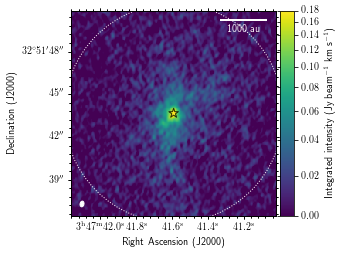

In [108]:
savefigure = True
fig = plt.figure(figsize=(4,4))
figname = figurefolder + 'B5IRS1_C18O_robust05_multi_mom0.pdf'
gc = plot_aplpy_subfig(c18omom0file, fig, (1,1,1), 'arcsinh', 0, 0.18, 'viridis', vmid=0.05, label_col='w',barsize=1000)

# gc.show_contour(c18omom0file, colors='w', levels=rms_mom0_c18o*np.array([3,5,10]), linewidths=0.5)
gc.recenter(ra_yso, dec_yso, 0.002)
gc.show_circles(ra_yso, dec_yso, (primary_beam_alma(freq_C18O)/2).to(u.deg).value, color='w', ls=':')
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k', s=100)
# gc.show_contour('gaussfit_H2CO/B5IRS1_H2COa_robust05_multi_3_cut_pbcor_K_mask.fits', levels=[1], colors='w', linestyles='--')
gc.beam.set_color('w')
gc.colorbar.set_axis_label_text(r'Integrated intensity (Jy beam$^{-1}$ km s$^{-1}$)')
gc.tick_labels.set_xformat('hh:mm:ss.s')


if savefigure:
    fig.savefig(figname, bbox_inches='tight')

### Channel maps of C$^{18}$O ($2-1$)

In [112]:
from astropy.visualization import simple_norm

if not os.path.exists(c18ocubefileK):
    cube_C18O = SpectralCube.read(h2cocubefile).with_spectral_unit(u.km/u.s)
    cube_C18O.allow_huge_operations=True
    cube_C18O = cube_H2CO.to(u.K)
    cube_C18O.hdu.writeto(c18ocubefileK)
else:
    cube_C18O = SpectralCube.read(c18ocubefileK).with_spectral_unit(u.km/u.s)
wcssky = WCS(cube_C18O.header).celestial

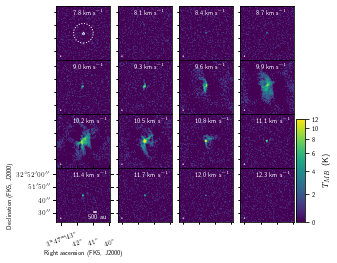

In [116]:
savefigure = True
figname = figurefolder + 'B5IRS1_C18O_robust05_multi_chanmap_{0}_{1}.pdf'.format(velinit.value,deltav.value)

ra_yso_pix, dec_yso_pix = wcssky.wcs_world2pix(ra_yso, dec_yso, 0)
ra_yso_pix, dec_yso_pix = float(ra_yso_pix), float(dec_yso_pix)
pbradius_c18o = (primary_beam_alma(freq_C18O)/2).to(u.deg).value / cube_C18O.header['CDELT2']
velinit = 7.8 * u.km / u.s
deltav = 0.3 * u.km / u.s
nrows = 4
ncols = 4
vmin = 0
vmax = 12
xmin = 150
xmax = 610
ymin = 150 
ymax = 610
bmaj, bmin = np.array([cube_C18O.header['BMAJ'], cube_C18O.header['BMIN']])/np.abs(cube_C18O.header['CDELT2'])
bpa = cube_C18O.header['BPA']-90
scalebarsize = 500
scalebarpix = int((scalebarsize / dist_B5.value) / 3600 / cube_C18O.header['CDELT2'])

velocity_array = cube_C18O.spectral_axis.value
velocity_sample = np.arange(velinit.value, velinit.value+(nrows*ncols*deltav.value), deltav.value) 


fig, axlist = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(6,4), subplot_kw={'projection': wcssky})
axlist = axlist.flatten()
for i, ax in enumerate(axlist):
    indexvel = np.argmin(np.abs(velocity_array-velocity_sample[i]))
    planevel = cube_C18O.unmasked_data[indexvel, :, :]
    norm = simple_norm(planevel, 'asinh', min_cut = vmin, max_cut=vmax, asinh_a=0.3)
    im = ax.imshow(planevel, norm=norm)#vmin = vmin, vmax=vmax)
    ax.annotate(str(np.round(velocity_sample[i], 2))+r' km s$^{-1}$', (0.3, 0.85), xycoords='axes fraction', color='w', size=6)
    beam = Ellipse((62, 59), bmaj, bmin, angle=bpa, ec = 'w', fc='w')
    ax.add_patch(beam)
    # ax.set_xlim([xmin, xmax])
    # ax.set_ylim([ymin, ymax])
    if i == 0:
        pb = Circle((ra_yso_pix, dec_yso_pix), pbradius_c18o, ec = 'w', fc='None', ls=':')
        ax.add_patch(pb)
        ax.scatter(ra_yso_pix, dec_yso_pix, marker='*', facecolor=None, edgecolor='w', s=10, linewidth=0.5)
    if not i == ncols*nrows - ncols:
        ax.tick_params(axis='x', which='both', bottom=True, labelbottom=False, length=2)
        ax.tick_params(axis='y', which='both', left=True, labelleft=False, length=2)
    else:
        # ax.set_xlabel('Right ascension (FK5, J2000)')
        # ax.set_ylabel('Declination (FK5, J2000)')
        lon = ax.coords[0]
        lat = ax.coords[1]
        lon.set_axislabel('Right ascension (FK5, J2000)', size=6)
        lat.set_axislabel('Declination (FK5, J2000)', size=6)
        lon.set_ticklabel(rotation=20,pad=15,ha='right', size=6)
        lat.set_ticklabel(size=6)
        ax.plot([550, 550+scalebarpix], [150, 150], color='w', lw=1.5)
        ax.annotate(str(scalebarsize)+' au', (0.58, 0.07), xycoords='axes fraction', color='w', size=6)
fig.tight_layout(pad=-1)
fig.subplots_adjust(left=0.2, right=0.98, bottom=0.15, top=0.9, hspace = 0, wspace=-0.6)
cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.36])
cbar = fig.colorbar(im, cax=cbar_ax, ticks=[0, 2, 4, 6, 8, 10, 12], label=r'$T_{MB}$ (K)')
cbar_ax.set_yticklabels(['0', '2', '4', '6', '8', '10', '12'])
cbar.set_label(label=r'$T_{MB}$ (K)', size=8)
cbar_ax.tick_params(labelsize=6)


if savefigure:
    fig.savefig(figname, dpi=300, bbox_inches='tight')
    

### Selected spectra

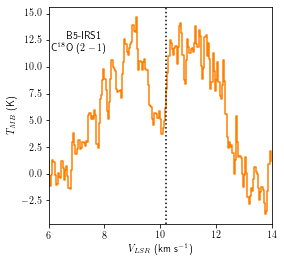

In [140]:
#spectra at the location of the protostar
savefig = True
colorC18O = '#ff7f00'
position = [ra_yso, dec_yso]
velinit = 6 * u.km/u.s
velend = 14 * u.km/u.s
label = r'B5-IRS1 \\ C$^{18}$O ($2-1$)'
figname = figurefolder + 'B5IRS1_C18O_robust05_multi_spectra_IRS1.pdf'

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$V_{LSR}$ (km s$^{-1}$)')
ax.set_ylabel(r'$T_{MB}$ (K)')
spectrum = get_spectra(cube_C18O, position, velinit, velend)
ax.plot(spectrum[0], spectrum[1], drawstyle='steps-mid', color=colorC18O)
ax.text(0.01, 0.85, label, horizontalalignment='left', transform=ax.transAxes, color='k', size=10)
ax.set_xlim([velinit.value, velend.value])
ax.axvline(10.2, color='k', linestyle='dotted', label=r'$V_{LSR}$ IRS1 (NH$_3$)')
if savefig:
    fig.savefig(figname, bbox_inches='tight')

        Use another way of creating angles instead (e.g. a less ambiguous string like '-0h1m2.3s' instead. [astropy.coordinates.angles]
        Use another way of creating angles instead (e.g. a less ambiguous string like '-0d1m2.3s' instead. [astropy.coordinates.angles]


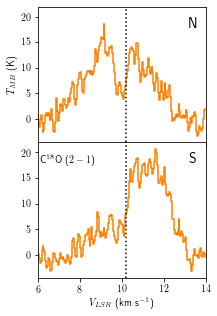

In [144]:
#spectra at selected locations in the possible gas disk
savefig = True
positions_C18O, labels_C18O = getPositionFromRegions(regions_alma_C18O_spectra)
positions_C18O.reverse()
labels_C18O.reverse()
velinit = 6 * u.km/u.s
velend = 14 * u.km/u.s
label = r'C$^{18}$O ($2-1$)'
figname = figurefolder + 'B5IRS1_C18O_robust05_multi_spectra_selected_regions.pdf'

fig, axes = plt.subplots(ncols=1, nrows=2, sharex=True, sharey=True, figsize=(3,5))
axes[1].set_xlabel(r'$V_{LSR}$ (km s$^{-1}$)')
axes[0].set_ylabel(r'$T_{MB}$ (K)')

for i in reversed(range(len(axes))):
    position = positions_C18O[i]
    spectrum = get_spectra(cube_C18O, position, velinit, velend)
    ax = axes[-(i-1)]
    ax.plot(spectrum[0], spectrum[1], drawstyle='steps-mid', color=colorC18O)
    ax.text(0.9, 0.85, labels_C18O[i], horizontalalignment='left', transform=ax.transAxes, color='k', size=14)
    ax.set_xlim([velinit.value, velend.value])
    ax.axvline(10.2, color='k', linestyle='dotted', label=r'$V_{LSR}$ IRS1 (NH$_3$)')
fig.subplots_adjust(hspace=0)
ax.text(0.01, 0.85, label, horizontalalignment='left', transform=ax.transAxes, color='k', size=10)
if savefig:
    fig.savefig(figname, bbox_inches='tight')

## ALMA observations: previous data from the archive

### Filenames

In [145]:
figurefolder = 'figures/'

so2cubefile = 'B5_IRS1_ALMA/2017.1.01462.S_Sakai_Higherres/B5IRS1_spw29_pbcor_SO2_14_014_13_113_K_contcorrected.fits'
so2mom0file = 'B5_IRS1_ALMA/2017.1.01462.S_Sakai_Higherres/B5IRS1_spw29_pbcor_SO2_14_014_13_113_K_contcorrected_8.5_12.1.fits'

h13copmom0file = 'B5_IRS1_ALMA/2017.1.01371.S_Hoff/B5-IRS1_H13COp_2_1_short_cut_K_mom0blue.fits'
h13copvlsrfile = 'B5_IRS1_ALMA/2017.1.01371.S_Hoff/B5-IRS1_H13COp_2_1_short_cut_K_kms_1G_fitparams_2_filtered_Vlsr.fits'
diffvlsrfile = 'B5_IRS1_ALMA/gaussfit_H2CO/analysis_central_chans_masked/B5_H2CO_blueshifted_envelope_minus_H13COp'

### H$^{13}$CO+ from van't Hoff et al (2022)

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cm.set_bad(color)


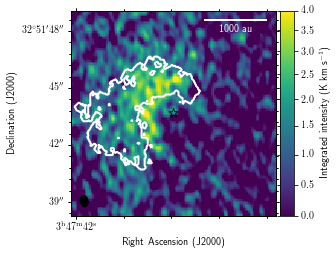

In [146]:
savefigure=True
figname = figurefolder + 'H13CO_mom0_wH2COcontour.pdf'

fig = plt.figure(figsize=(4,4))
gc = plot_aplpy_subfig(h13copmom0file, fig, (1,1,1), 'arcsinh', 0, 4.000, 'viridis', label_col='k', vmid=3.000, barsize=1000)
gc.recenter(ra_yso, dec_yso, 0.0015)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k', s=100)
gc.scalebar.set_color('w')
gc.colorbar.set_axis_label_text('Integrated intensity (K km s$^{-1}$)')
footprint_h2co_blue = np.isfinite(fits.getdata(h2cotpeakbluefile)).astype(int)
gc.show_contour(fits.PrimaryHDU(footprint_h2co_blue, fits.getheader(h2cotpeakbluefile)), colors='w', levels=[0.5], linewidths=2)
if savefigure:
    fig.savefig(figname, bbox_inches='tight')

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  cm.set_bad(color)


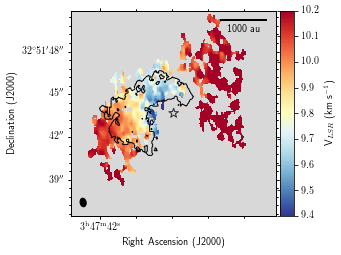

In [147]:
savefigure = True
figname = figurefolder + 'H13CO_1G_fitparams_2_filtered_Vlsr.pdf'

fig = plt.figure(figsize=(4,4))
gc = plot_aplpy_subfig(h13copvlsrfile, fig, (1,1,1), 'linear', 10.2-0.8, 10.2, 'RdYlBu_r', label_col='k', barsize=1000)
gc.recenter(ra_yso, dec_yso, 0.002)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k', s=100)
footprint_h2co_blue = np.isfinite(fits.getdata(h2cotpeakbluefile)).astype(int)
gc.show_contour(fits.PrimaryHDU(footprint_h2co_blue, fits.getheader(h2cotpeakbluefile)), colors='k', levels=[0.5], linewidths=1)
gc.colorbar.set_axis_label_text('V$_{LSR}$ (km s$^{-1}$)')
if savefigure:
    fig.savefig(figname, bbox_inches='tight')

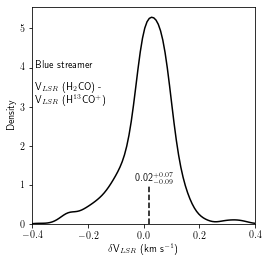

In [148]:
savefigure = True
figname = figurefolder + 'components_blueshifted_envelope_diff_wr_H13COp.pdf'

data, dens, vlsr_median_unc = np.load(diffvlsrfile+'.npy', allow_pickle=True)

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.plot(data, dens, color='k')
ax.plot([vlsr_median_unc[1], vlsr_median_unc[1]], [0, 1], color='k', ls='--')
ax.text(vlsr_median_unc[1]-0.05,1.1,r'{0}$_{{{1:.2f}}}^{{+{2:.2f}}}$'.format(vlsr_median_unc[1], vlsr_median_unc[0]-vlsr_median_unc[1], vlsr_median_unc[2]-vlsr_median_unc[1]), size=10)
ax.set_xlabel(r'$\delta$V$_{LSR}$ (km s$^{-1}$)')
ax.set_ylabel('Density')
ax.set_xlim([-0.4, 0.4])
ax.set_ylim(bottom=0)
ax.text(-0.39, 4, 'Blue streamer ', size=10)
ax.text(-0.39, 3.1, 'V$_{LSR}$ (H$_2$CO) -\n V$_{LSR}$ (H$^{13}$CO$^+$)')

if savefigure:
    fig.savefig(figname, bbox_inches='tight')

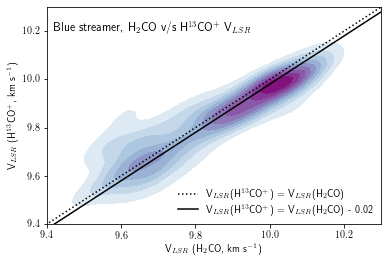

In [149]:
savefigure = True
figname = figurefolder + 'components_blueshifted_envelope_vlsr_comparison_H13COp.pdf'

xx, yy, zz = np.load(diffvlsrfile+'_2DKDE.npy')
def shifted_line(velx, shift):
    return velx + shift

linesample = np.linspace(9.2, 10.6, 10)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(xx, yy, zz, cmap='BuPu', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
ax.plot(linesample, linesample, 'k:', label='V$_{LSR}$(H$^{13}$CO$^+$) = V$_{LSR}$(H$_2$CO)')
ax.plot(linesample, shifted_line(linesample, -0.02), 'k-', label='V$_{LSR}$(H$^{13}$CO$^+$) = V$_{LSR}$(H$_2$CO) - 0.02')
ax.set_xlabel('V$_{LSR}$ (H$_2$CO, km s$^{-1}$)')
ax.set_ylabel('V$_{LSR}$ (H$^{13}$CO$^+$, km s$^{-1}$)')
ax.text(9.42, 10.2, 'Blue streamer, H$_2$CO v/s H$^{13}$CO$^+$ V$_{LSR}$', size=12)
ax.set_xlim([9.4, 10.3])
ax.set_ylim([9.4, 10.3])
ax.legend(frameon=False, loc=4)

if savefigure:
    fig.savefig(figname, bbox_inches='tight')

### SO$_2$ from Sakai et al. (PEACHES)

In [150]:
so2cube = SpectralCube.read(so2cubefile).with_spectral_unit(u.km/u.s)

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cm.set_bad(color)


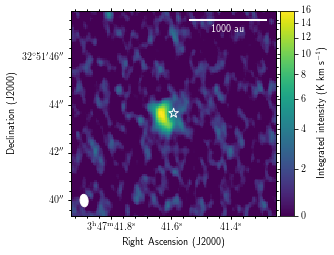

In [151]:
savefigure = True
fig = plt.figure(figsize=(4,4))
figname = figurefolder + 'B5IRS1_SO2_mom0.pdf'
gc = plot_aplpy_subfig(so2mom0file, fig, (1,1,1), 'arcsinh', 0, 16, 'viridis', vmid=4, label_col='w',barsize=1000)
gc.recenter(ra_yso, dec_yso, 0.0012)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=1, layer='lay_yso',  facecolor='None', edgecolor='w', s=100)
gc.beam.set_color('w')
gc.colorbar.set_axis_label_text(r'Integrated intensity (K km s$^{-1}$)')
gc.tick_labels.set_xformat('hh:mm:ss.s')

if savefigure:
    fig.savefig(figname, bbox_inches='tight')

/tmp/ipykernel_36791/69673905.py:46: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout(pad=0)


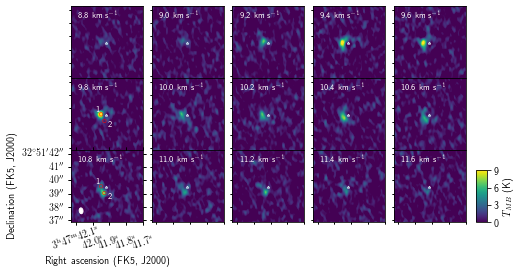

In [152]:
savefigure = True

wcsskyso2 = WCS(so2cube.header).celestial    
ra_yso_pixso2, dec_yso_pixso2 = wcsskyso2.wcs_world2pix(ra_yso, dec_yso, 0)
ra_yso_pixso2, dec_yso_pixso2 = float(ra_yso_pixso2), float(dec_yso_pixso2)
bmaj, bmin = np.array([so2cube.header['BMAJ'], so2cube.header['BMIN']])/np.abs(so2cube.header['CDELT2'])
bpa = so2cube.header['BPA']-90

velinit = 8.8 * u.km/u.s
deltav = 0.2 * u.km/u.s
figname = figurefolder + 'B5IRS1_SO2_chanmap_{0}_{1}.pdf'.format(velinit.value,deltav.value)
nrows = 3
ncols = 5
vmax = 9
vmin = 0
velocity_array = so2cube.spectral_axis.value
velocity_sample = np.arange(velinit.value, velinit.value+(nrows*ncols*deltav.value), deltav.value) 

fig, axlist = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(8,4), subplot_kw={'projection': wcssky})
axlist = axlist.flatten()
for i, ax in enumerate(axlist):
    indexvel = np.argmin(np.abs(velocity_array-velocity_sample[i]))
    planevel = so2cube.unmasked_data[indexvel, :, :]
    im = ax.imshow(planevel, vmin = vmin, vmax=vmax)
    ax.annotate(str(np.round(velocity_sample[i], 2))+r' km s$^{-1}$', (0.1, 0.85), xycoords='axes fraction', color='w', size=8)
    ax.set_xlim([316-50, 316+50])
    ax.set_ylim([316-50, 316+50])
    # ax.scatter(ra_yso_pix, dec_yso_pix, marker='*', facecolor=None, edgecolor='w', s=8, linewidth=0.5)
    ax.scatter(ra_yso_pixso2, dec_yso_pixso2, marker='*', facecolor=None, edgecolor='w', s=8, linewidth=0.5)   
    if np.round(velocity_sample[i], 2) == 9.8 or np.round(velocity_sample[i], 2) == 10.8:
        ax.scatter(307.8, 316, marker='o', facecolor='none', edgecolor='r', s=12, linewidth=0.5) # peak 1
        ax.text(301, 320, '1', c='w', size=8)
        ax.scatter(312.34056, 306.65427, marker='o', facecolor='none', edgecolor='r', s=12, linewidth=0.5) # peak2
        ax.text(317, 300, '2', c='w', size=8)
    if not i == ncols*nrows - ncols:
        ax.tick_params(axis='x', which='both', bottom=True, labelbottom=False, length=2)
        ax.tick_params(axis='y', which='both', left=True, labelleft=False, length=2)
    else:
        lon = ax.coords[0]
        lat = ax.coords[1]
        lon.set_axislabel('Right ascension (FK5, J2000)', size=10)
        lat.set_axislabel('Declination (FK5, J2000)', size=10)
        lon.set_ticklabel(rotation=20,pad=15,ha='right')
        beam = Ellipse((280, 282), bmaj, bmin, angle=bpa, ec = 'w', fc='w')
        ax.add_patch(beam)
fig.tight_layout(pad=0)
fig.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.9)
cbar_ax = fig.add_axes([0.86, 0.15, 0.02, 0.18])
fig.colorbar(im, cax=cbar_ax, label=r'$T_{MB}$ (K)', ticks=[0, 3, 6, 9])
cbar_ax.set_yticklabels(['0', '3', '6', '9'])
fig.subplots_adjust(hspace = -0, wspace=0) 

if savefigure:
    fig.savefig(figname, bbox_inches='tight')
    

### Spectra of selected regions

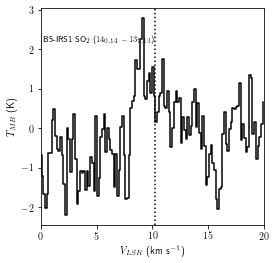

In [153]:
# spectra at the location of the protostar
savefig = True

position = ra_yso, dec_yso
velinitspec = 0 * u.km / u.s
velendspec = 20 * u.km / u.s

label = r'B5-IRS1 SO$_{2}$ ($14_{0, 14}-13_{1, 13}$)'
figname = figurefolder + 'B5IRS1_SO2_14_0_14_13_1_13_spectra_IRS1.pdf'

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$V_{LSR}$ (km s$^{-1}$)')
ax.set_ylabel(r'$T_{MB}$ (K)')
spectrum = get_spectra(so2cube, position, velinitspec, velendspec)

ax.plot(spectrum[0], spectrum[1], drawstyle='steps-mid', color='k')
ax.text(0.01, 0.85, label, horizontalalignment='left', transform=ax.transAxes, color='k', size=8)
ax.set_xlim([velinitspec.value, velendspec.value])
ax.axvline(10.2, color='k', linestyle='dotted', label=r'$V_{LSR}$ IRS1 (NH$_3$)')
if savefig:
    fig.savefig(figname, bbox_inches='tight')

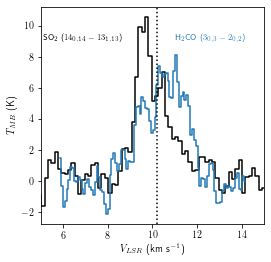

In [154]:
# spectra at the peak of SO2 emission
savefig = True

position_peak = 56.9234836*u.deg, 32.8621240*u.deg
velinitspec = 5 * u.km / u.s
velendspec = 15 * u.km / u.s

label = r'SO$_{2}$ ($14_{0, 14}-13_{1, 13}$)'
figname = figurefolder + 'B5IRS1_SO2_14_0_14_13_1_13_spectra_peak1_wH2CO.pdf'

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$V_{LSR}$ (km s$^{-1}$)')
ax.set_ylabel(r'$T_{MB}$ (K)')
spectrum = get_spectra(so2cube, position_peak , velinitspec, velendspec)
spectrum_H2CO = get_spectra(cube_H2CO, position_peak , velinitspec, velendspec)

ax.plot(spectrum[0], spectrum[1], drawstyle='steps-mid', color='k')
ax.plot(spectrum_H2CO[0], spectrum_H2CO[1], drawstyle='steps-mid', color='C0')
ax.text(0.01, 0.85, label, horizontalalignment='left', transform=ax.transAxes, color='k', size=8)
ax.text(0.6, 0.85, r'H$_{2}$CO ($3_{0, 3}- 2_{0,2}$)', horizontalalignment='left', transform=ax.transAxes, color='C0', size=8)
ax.set_xlim([velinitspec.value, velendspec.value])
ax.axvline(10.2, color='k', linestyle='dotted', label=r'$V_{LSR}$ IRS1 (NH$_3$)')
if savefig:
    fig.savefig(figname, bbox_inches='tight')

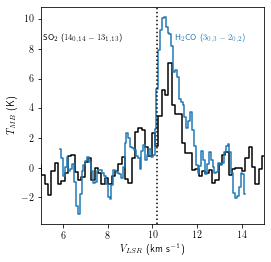

In [155]:
# spectra at the second peak of SO2 emission
savefig = True

position_peak = 56.9233867*u.deg, 32.8619561*u.deg
velinitspec = 5 * u.km / u.s
velendspec = 15 * u.km / u.s

label = r'SO$_{2}$ ($14_{0, 14}-13_{1, 13}$)'
figname = figurefolder + 'B5IRS1_SO2_14_0_14_13_1_13_spectra_peak2.pdf'

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$V_{LSR}$ (km s$^{-1}$)')
ax.set_ylabel(r'$T_{MB}$ (K)')
spectrum = get_spectra(so2cube, position_peak, velinitspec, velendspec)
spectrum_H2CO = get_spectra(cube_H2CO, position_peak, velinitspec, velendspec)

ax.plot(spectrum[0], spectrum[1], drawstyle='steps-mid', color='k')
ax.plot(spectrum_H2CO[0], spectrum_H2CO[1], drawstyle='steps-mid', color='C0')
ax.text(0.01, 0.85, label, horizontalalignment='left', transform=ax.transAxes, color='k', size=8)
ax.text(0.6, 0.85, r'H$_{2}$CO ($3_{0, 3}- 2_{0,2}$)', horizontalalignment='left', transform=ax.transAxes, color='C0', size=8)
ax.set_xlim([velinitspec.value, velendspec.value])
ax.axvline(10.2, color='k', linestyle='dotted', label=r'$V_{LSR}$ IRS1 (NH$_3$)')
if savefig:
    fig.savefig(figname, bbox_inches='tight')

## VLA + GBT observations: NH$_3$

We have loaded the NH$_3$ files in the NOEMA section as we needed them before.


/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("coolwarm").copy()
  cm.set_bad(color)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found 

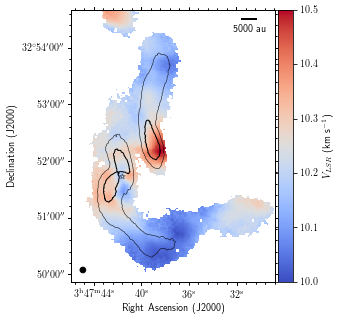

In [27]:
# velocity fit of NH3, in the same absolute scale as HC3N
savefigure = False
fig = plt.figure(figsize=(5,5))
figname = figdir + 'NH311_dv_wcont.pdf'
gc = plot_aplpy_subfig(nh3velocityfile, fig, (1,1,1), 'linear', 10.0, 10.5, 'coolwarm')
# gc.recenter(56.9067231, 32.8660922, 0.035)
gc.recenter(56.9055921,32.8711272,width=0.06,height=0.08)
gc.show_contour(maskC1file, colors='k', linewidths=1)
gc.show_contour(maskC2file, colors='k', linewidths=1)
gc.show_contour(maskC3file, colors='k', linewidths=1)
gc.show_contour(nh3mom0file, colors='black', linewidths=0.5, levels=nh3mom0levels, zorder=34)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.5, layer='lay_yso',  facecolor='None', edgecolor='k')
gc.set_nan_color('w')
gc.colorbar.set_axis_label_text(r'$V_{LSR}$ (km s$^{-1}$)')
if savefigure:
    fig.savefig(figname, bbox_inches='tight')

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  cm.set_bad(color)


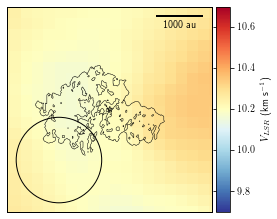

In [132]:
# zoomed velocity fit of NH3, compared to the ALMA streamer
savefig = True
fig = plt.figure(figsize=(4,5))
figname = figdir + 'NH311_dv_ALMAcontour.pdf'

stretch = 'linear'
vmin = 10.2-0.5
vmax = 10.2+0.5

filenamecontour = 'B5_IRS1_ALMA/gaussfit_H2CO/analysis_central_chans_masked/B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_1G_fitparams_total_aicres.fits'
filenameheader = 'B5_IRS1_ALMA/gaussfit_H2CO/analysis_central_chans_masked/B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_total_ncomponents.fits'
tpeak_h2coalma = fits.getdata(filenamecontour)[0]
tpeakheader = fits.getheader(filenameheader)
tpeak = np.where(~np.isnan(tpeak_h2coalma), 1,0)

gc = plot_aplpy_subfig(nh3velocityfile, fig, (1,1,1), stretch, vmin, vmax, 'RdYlBu_r', barsize=1000)
gc.ticks.hide()
gc.tick_labels.hide()
gc.axis_labels.hide()
gc.recenter(ra_yso, dec_yso, 0.002)
gc.beam.set_facecolor('None')
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k')
gc.colorbar.set_axis_label_text(r'$V_{LSR}$ (km s$^{-1}$)')
gc.show_contour(fits.PrimaryHDU(tpeak, tpeakheader), colors='k', levels=[0.5], linewidths=0.5)
if savefig:
    fig.savefig(figname, bbox_inches='tight')

## Comparison between  HC$_3$N and NH$_3$ Velocities along the filaments

In [119]:
vlsrdifffile = 'B5_Vlsr_HC3N_minus_NH3.fits'
vlsrdiffkdefile = 'B5_Vlsr_HC3N_minus_NH3'


/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  cm.set_bad(color)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found 

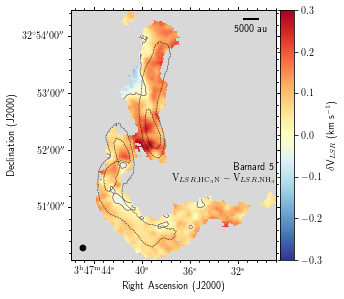

In [120]:
savefigure = False
fig = plt.figure(figsize=(4,8))
figname = figurefolder + 'B5_HC3N_minus_NH3.pdf'
velmin = -0.3
velmax = 0.3
ax = plot_aplpy_subfig(vlsrdifffile, fig, (1,1,1), 'linear', velmin, 
                       velmax, 'RdYlBu_r')
ax.show_contour(vlsrdifffile, levels=[0], linewidths=0.5)
ax.show_contour(maskC1file, colors='k', linewidths=0.5, linestyles='dashed')
ax.show_contour(maskC2file, colors='k', linewidths=0.5, linestyles='dashed')
ax.show_contour(maskC3file, colors='k', linewidths=0.5, linestyles='dashed')
ax.recenter(56.9055921,32.8711272,width=0.06,height=0.08)
ax.show_contour(nh3mom0file, colors='k', linewidths=0.5, linestyles='dashed', levels=nh3mom0levels, zorder=34)
# ax.colorbar.set_axis_label_text(r'$V_{\mathrm{LSR},\mathrm{HC}_3\mathrm{N}(10-9)} - V_{\mathrm{LSR}, \mathrm{NH}_3(1,1)}$ (km s$^{-1}$)')
ax.colorbar.set_axis_label_text(r'$\delta$V$_{LSR}$ (km s$^{-1}$)')
ax.recenter(56.9055921,32.8711272,width=0.06,height=0.073)
# ax.show_markers(ra_yso, dec_yso, marker='*', alpha=0.5, layer='lay_yso',  facecolor='None', edgecolor='k')
ax.add_label(0.99,0.35, 'Barnard 5\n$\mathrm{V}_{LSR, \mathrm{HC}_3\mathrm{N}} - \mathrm{V}_{LSR, \mathrm{NH}_3}$', relative=True, color='k', size=10, horizontalalignment='right')
# ax.show_contour(nh3mom0file, colors='black', linewidths=0.5, levels=nh3mom0levels, zorder=34)
if savefigure:
    fig.savefig(figname, bbox_inches='tight')

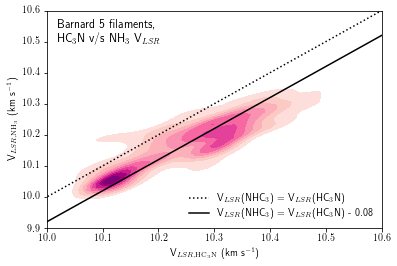

In [121]:
# 2D KDE of the velocities
savefigure = True
figname = figurefolder + 'B5_HC3N_v_lsr_compared_NH3.pdf'

xx, yy, zz = np.load(vlsrdiffkdefile+'_2DKDE.npy')
def shifted_line(velx, shift):
    return velx + shift

linesample = np.linspace(9.8, 10.8, 10)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(xx, yy, zz, cmap='RdPu', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
ax.plot(linesample, linesample, 'k:', label='V$_{LSR}$(NHC$_{3}$) = V$_{LSR}$(HC$_3$N)')
ax.plot(linesample, shifted_line(linesample, -0.08), 'k-', label='V$_{LSR}$(NHC$_{3}$) = V$_{LSR}$(HC$_3$N) - 0.08')
ax.set_xlabel(r'V$_{LSR, \mathrm{HC}_3\mathrm{N}}$ (km s$^{-1}$)')
ax.set_ylabel(r'V$_{LSR, \mathrm{NH}_3}$ (km s$^{-1}$)')
ax.text(10.02, 10.5, 'Barnard 5 filaments,\n HC$_3$N v/s NH$_{3}$ V$_{LSR}$', size=12)
ax.set_xlim([10, 10.6])
ax.set_ylim([9.9, 10.6])
ax.legend(frameon=False, loc=4)
# $\mathrm{V}_{LSR, \mathrm{HC}_3\mathrm{N}} - \mathrm{V}_{LSR, \mathrm{NH}_3}$
if savefigure:
    fig.savefig(figname, bbox_inches='tight')

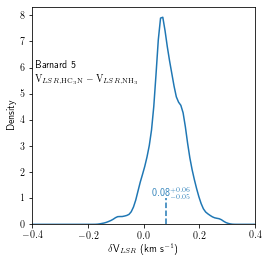

In [122]:
# KDE of the velocity difference
savefigure = True
fig = plt.figure(figsize=(4,4))
figname = figurefolder + 'B5_HC3N_minus_NH3_kde.pdf'
data, dens, vlsr_median_unc = np.load(vlsrdiffkdefile+'.npy', allow_pickle=True)

ax = fig.add_subplot(111)
# ax.hist(data, fc='k', bins='sturges', density=True)
ax.plot(data, dens)
ax.plot([vlsr_median_unc[1], vlsr_median_unc[1]], [0, 1], color='C0', ls='--')
ax.text(vlsr_median_unc[1]-0.05,1.1,r'{0}$_{{{1:.2f}}}^{{+{2:.2f}}}$'.format(vlsr_median_unc[1], vlsr_median_unc[0]-vlsr_median_unc[1], vlsr_median_unc[2]-vlsr_median_unc[1]), size=10, color='C0')

ax.set_xlabel(r'$\delta$V$_{LSR}$ (km s$^{-1}$)')
ax.set_ylabel('Density')
ax.set_xlim([-0.4, 0.4])
ax.set_ylim(bottom=0)
ax.text(-0.39, 6, 'Barnard 5', size=10)
ax.text(-0.39, 5.5, '$\mathrm{V}_{LSR, \mathrm{HC}_3\mathrm{N}} - \mathrm{V}_{LSR, \mathrm{NH}_3}$')

if savefigure:
    fig.savefig(figname, bbox_inches='tight')

We make a selection along the pixels at the position of the protostar in the HC$_3$N map and sample the velocities in a horizontal line